# Analysis and Benchmark

> This notebook contains all of the results of scDenorm's analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x7fc702540200>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from tqdm import tqdm
from pathlib import Path
from typing import Union, Optional
import pickle
import seaborn as sns

In [4]:
from scipy import sparse
from scipy.optimize import fsolve,minimize

In [5]:
from scDenorm.denorm import *

# Fig 1. The data distribution of droplet-based single-cell data

In [ ]:
ad=sc.datasets.pbmc3k()

In [ ]:
smtx = ad.copy().X.tocsr().asfptype()
sc.pp.normalize_total(ad, target_sum=1e4)
smtx1 = ad.copy().X.tocsr().asfptype()
sc.pp.log1p(ad)
smtx2 = ad.copy().X.tocsr().asfptype()

In [ ]:
smtx.shape[0]

2700

In [ ]:
tmp=pd.DataFrame(pd.Series(smtx[1].data).value_counts())

In [ ]:
tmp.columns=['frequency']

In [ ]:
tmp['count']=[int(i) for i in list(tmp.index)]

In [ ]:
tmp['rank']=[i+1 for i in range(tmp.shape[0])]

In [ ]:
tmp=tmp.sort_index()

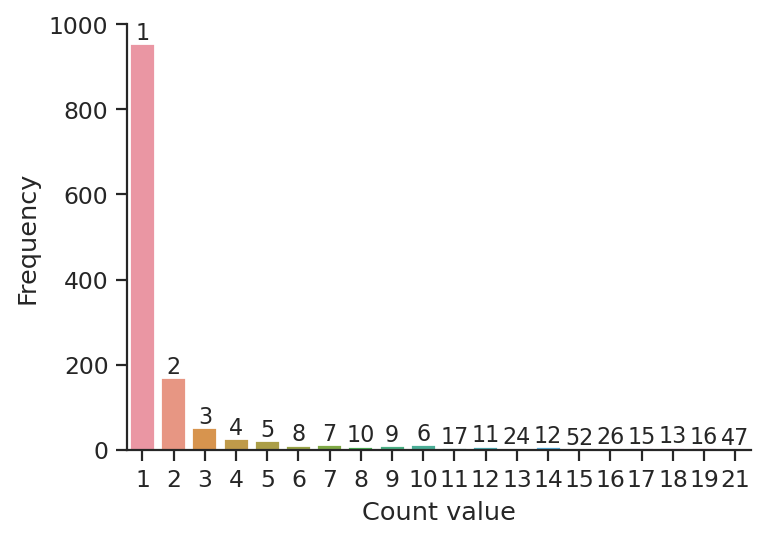

In [ ]:
figsize(5,3.5)
# Create a bar plot
sns.barplot(x='count', y='frequency', data=tmp.iloc[:20, :])

# Set plot properties
plt.grid(visible=False)
#plt.ylim(0, 200)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add text on top of the bars
for p,r in zip(ax.patches,tmp.iloc[:20,:]['rank']):
    height = p.get_height()
    ax.annotate(f'{r}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)
plt.xlabel('Count value')
plt.ylabel('Frequency')
# Show the plot
plt.show()

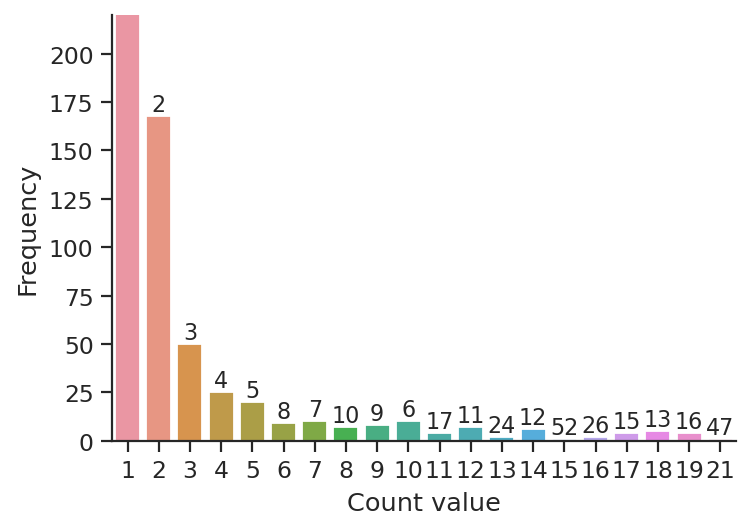

In [ ]:
figsize(5,3.5)
# Create a bar plot
sns.barplot(x='count', y='frequency', data=tmp.iloc[:20, :])

# Set plot properties
plt.grid(visible=False)
plt.ylim(0, 220)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add text on top of the bars
for p,r in zip(ax.patches,tmp.iloc[:20,:]['rank']):
    height = p.get_height()
    ax.annotate(f'{r}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)
plt.xlabel('Count value')
plt.ylabel('Frequency')
# Show the plot
plt.show()

In [ ]:
def RCplot(smtx,xl='Rank of count frequency',yl='Count value',xm=None,ym=None,alpha=1,save=None):
    fig, ax = plt.subplots()
    for c_idx in range(smtx.shape[0]):
        c = pd.Series(smtx.getrow(c_idx).data)
        c=c.value_counts().sort_index()
        y = np.array(c.index)
        x = np.arange(0, c.shape[0])+1
        ax.scatter(x, y,alpha=alpha);


    #ax.legend(fontsize=15,bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.spines[['right', 'top']].set_visible(False)
    #ax.tick_params(axis='both', which='major')#, labelsize=15)
    #ax.tick_params(axis='both', which='minor')#, labelsize=8)
    ax.set_xlabel(xl)#,fontsize=18)
    ax.set_ylabel(yl)#,fontsize=18)
    if ym:
        plt.ylim(0,ym)
    if xm:
        plt.xlim(0,xm)
        plt.plot(np.arange(xm),np.arange(xm),'k-', alpha=1, zorder=0)
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

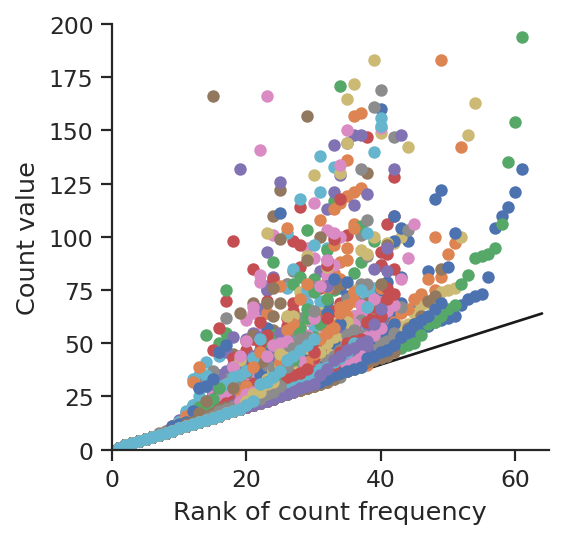

In [ ]:
figsize(3.5,3.5)
RCplot(smtx[:200],xm=65,ym=200,save='figures/rank/pbmc_rankvscount.pdf')

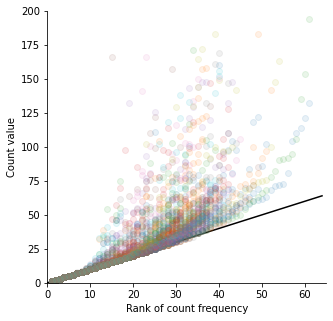

In [ ]:
RCplot(smtx[:200],xm=65,ym=200,alpha=0.1)

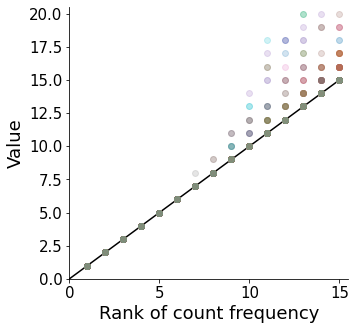

In [ ]:
RCplot(smtx[:200],xm=15.5,ym=20.5,alpha=0.2,save='figures/rank/pbmc_rankvscount_xlim15.pdf')

### Mean and variance (add NB fitted curve !!!)

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def fit_nb(ms):
    
    def nb_func(x, phi):
        return x[0] + (phi * x[0] ** 2)
    
    popt, _ = curve_fit(nb_func, ms['mean'], ms['var'], p0=[1])
    phi = popt[0]
    
    ms['zeros_p'] = np.exp(-ms['mean'])
    ms['zeros_nb'] = (1 + phi * ms['mean']) ** (-1 / phi)
    ms['newVar'] = ms['mean'] + phi * ms['mean'] ** 2
    return ms

In [ ]:
def plot_mv(cmean,cvar,c='blue',fit=False,save=None):
    fig, ax = plt.subplots()
    #ax.loglog()
    ax.set_xscale('log') 
    ax.scatter(cmean, cvar,s=20,c=c)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    #ax.plot(lims, lims, linestyle='--', linewidth=2, alpha=0.75, zorder=0,color='black', label='line')
    #ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Mean',fontsize=18)
    ax.set_ylabel('Variance',fontsize=18)
    
    if fit:
        ms=pd.DataFrame({'mean':cmean[0],'var':cvar[0]})
        ms=fit_nb(ms)
        ms=ms.sort_values('mean')
        plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1, zorder=ms.shape[0],color='red', label='line')
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_4832/783768956.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1, zorder=ms.shape[0],color='red', label='line')


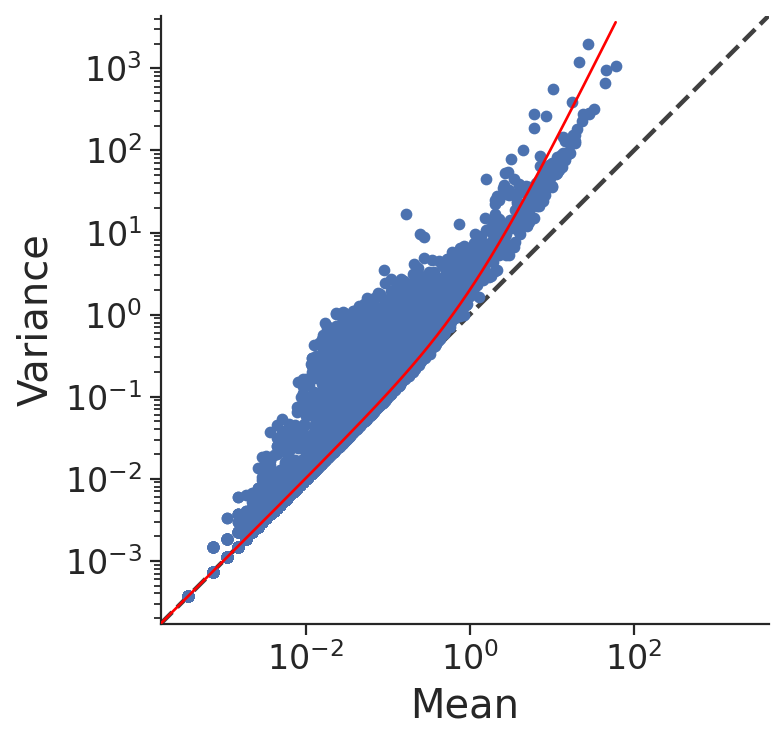

In [ ]:
figsize(5,5)
cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='#4C72B0',fit=True,save='figures/pbmc_mvsv_raw_count.pdf')

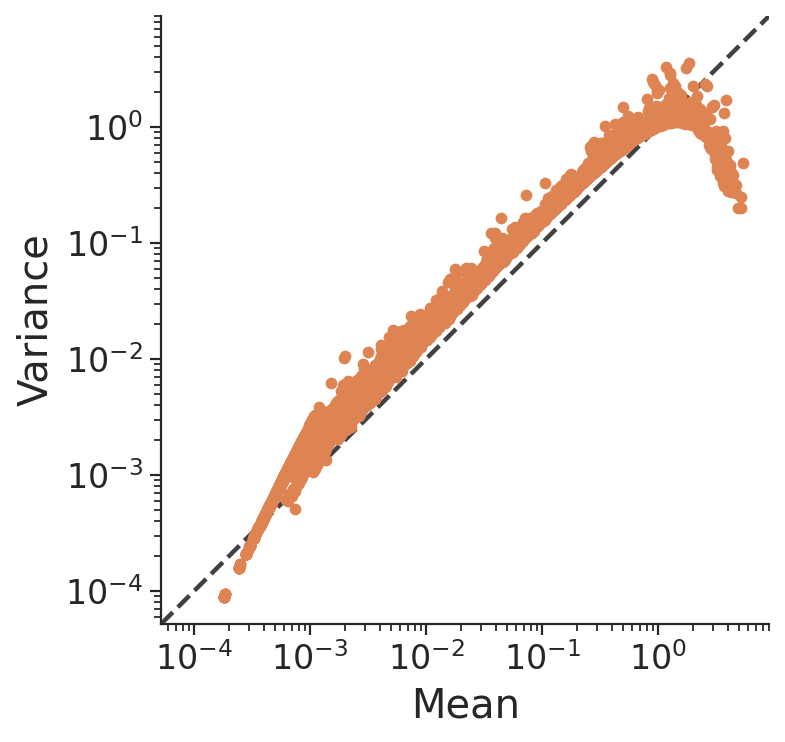

In [ ]:
cmean = np.array(smtx2.mean(0))
cvar = np.array(smtx2.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='#DD8452',fit=False,save='figures/pbmc_mvsv_normalized_count.pdf')

In [ ]:
def plot_mv(cmean,cvar,c='blue',fit=False,save=None):
    fig, ax = plt.subplots()
    #ax.loglog()
    #ax.set_xscale('log') 
    ax.scatter(cmean, cvar,s=20,c=c)
   

    #ax.plot(lims, lims, linestyle='--', linewidth=2, alpha=0.75, zorder=0,color='black', label='line')
    #ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
  
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Mean',fontsize=18)
    ax.set_ylabel('Variance',fontsize=18)
    
    if fit:
        ms=pd.DataFrame({'mean':cmean[0],'var':cvar[0]})
        ms=fit_nb(ms)
        ms=ms.sort_values('mean')
        plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1, zorder=ms.shape[0],color='red', label='line')
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

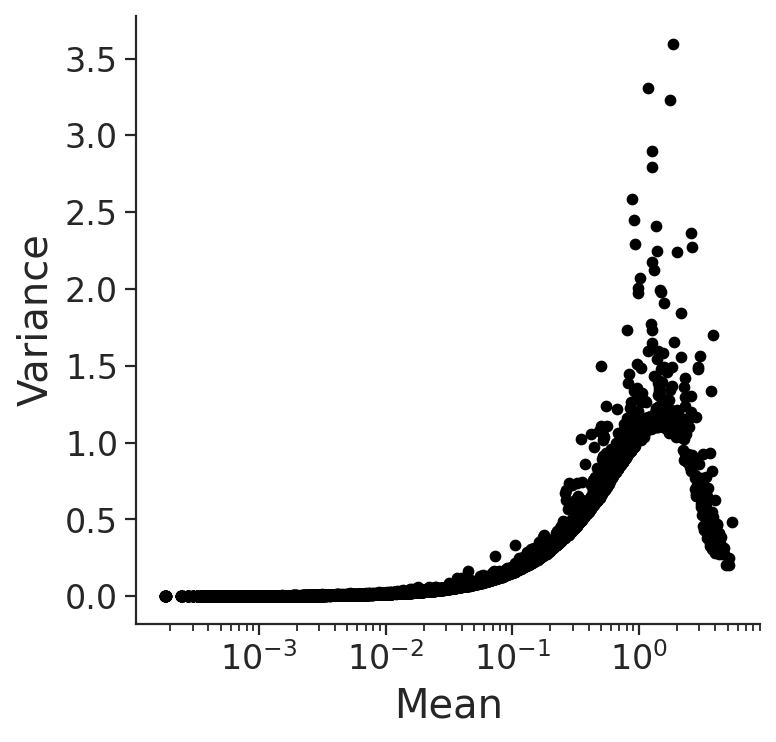

In [ ]:
cmean = np.array(smtx2.mean(0))
cvar = np.array(smtx2.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='black',fit=False)

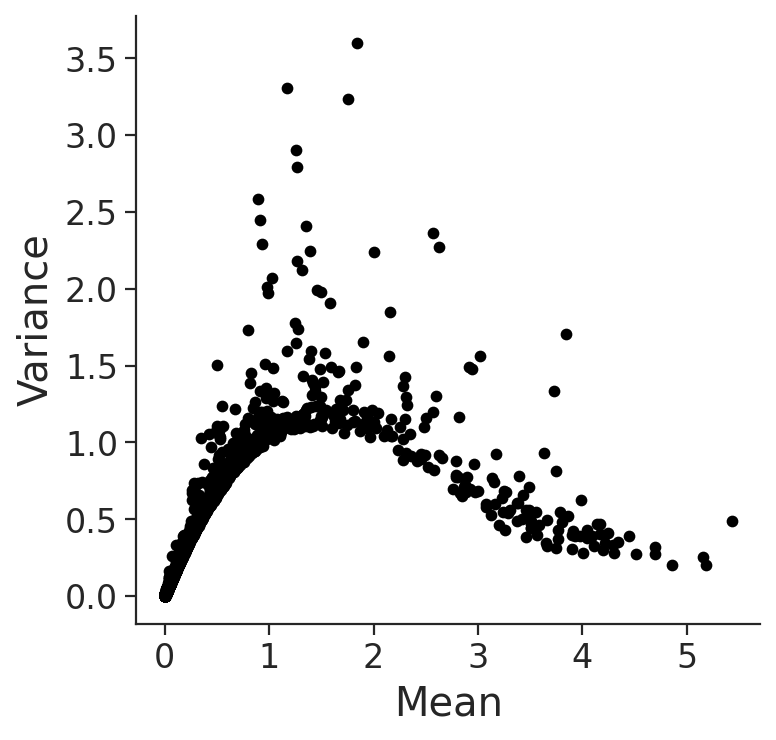

In [ ]:
cmean = np.array(smtx2.mean(0))
cvar = np.array(smtx2.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='black',fit=False)

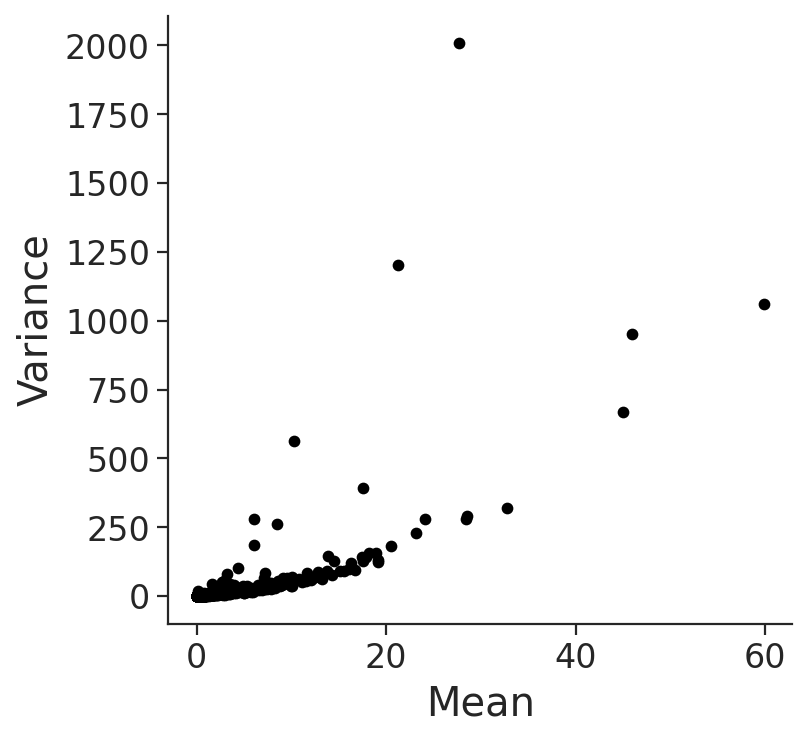

In [ ]:
figsize(5,5)
cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='black')

## Top N count and rank consistency

## sum of de-normalisation 

In [ ]:
smtx1.getrow(c_idx).data.sum()

10000.0

In [ ]:
tmp=pd.Series([(smtx1.getrow(i).data+1).sum() for i in range(smtx1.shape[0])])

<AxesSubplot:>

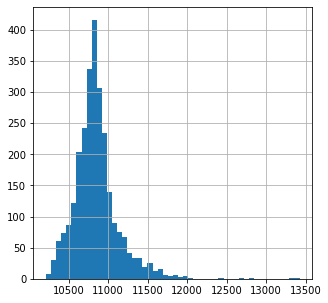

In [ ]:
tmp.hist(bins=50)

In [ ]:
def histplot(data,color,xl='Value',yl='Frequency',save=None):
    fig, ax = plt.subplots()
    # Create the histogram using Seaborn
    sns.histplot(data, kde=False, color=color, legend=False,ax = ax)
   
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(xl,fontsize=18)
    ax.set_ylabel(yl,fontsize=18)
    # Save the plot in a Nature journal style
    if save:
        plt.savefig(save,dpi=300,bbox_inches='tight',transparent=True)
    plt.show()

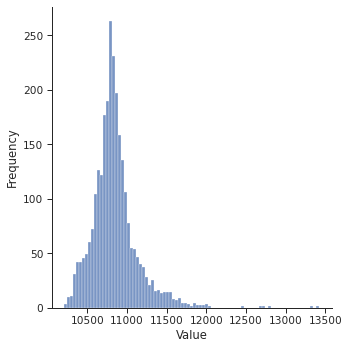

In [ ]:
histplot(tmp,color='#2077B4',save='figures/pbmc_sum_scaled_count+pseudo.pdf')

## violin plot for multiple dataset with different seq-tech

In [ ]:
brain_df=pd.read_csv('data/Main Data Sources - Brain.csv')

In [ ]:
brain_df.columns

Index(['human_brain_fetal_Braun_2022_10x', 'id', 'Project', 'a', 'Year',
       'Title', 'Ref', '#Cell Reported', 'Download Link', 'Accession code',
       'JIE-mark', 'Disease', 'Type', 'Tissue (Original Name)', 'Region1',
       'Region 2', 'Region 3', 'Cell Source', 'Organism', 'Technology', 'en',
       'Donwload Notes', 'Download', '#Cell Downloaded', 'rawdata path',
       'h5ad', 'h5ad path', 'Conversion Notes', 'tsv ', 'metadata',
       '4000 gene', 'Unnamed: 31', 'fine anno', 'manul anno', 'need anno',
       '注释情况核对', 'Contact', 'QC', '#gene', 'In-use', 'metadata.1'],
      dtype='object')

In [ ]:
sub_df=brain_df[(~brain_df['h5ad path'].isna()) & brain_df.Technology.isin(['Chromium','Drop-seq','Smart-seq2'])]

In [ ]:
sub_df[['rawdata path','h5ad', 'h5ad path','Organism','Technology']]

rawdata path  h5ad  \
0    human_chimpanzee_bonobo_macaque_Khrameeva_2020...   1.0   
1              human_brain_Microglia_Schirmer_2019_10x   1.0   
3                       human_brain_CNS_Marsh_2022_10x   1.0   
5                                                  NaN   1.0   
6               human_brain_WhiteMatter_Jakel_2019_10x   1.0   
..                                                 ...   ...   
193        mouse_brain_mycroglia_myeloid_Li_2018_smart   1.0   
194           mouse_brain_Astrocytes_Batiuk_2020_smart   1.0   
199                      mouse_brain_Ikonomou_2020_10x   1.0   
204             mouse_brain_Amygdala_Peters_2022_mFISH   0.0   
219   mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2   1.0   

                                             h5ad path  \
0    human_chimpanzee_bonobo_macaque_brain_Khrameev...   
1    /home/huang_ziliang/project/brain/data/public/...   
3                    human_brain_CNS_Marsh_2022_10x/h5   
5                                            not human   
6    /home/huang_ziliang/project/brain/data/public/...   
..                                                 ...   
193     mouse_brain_mycroglia_myeloid_Li_2018_smart/h5   
194        mouse_brain_Astrocytes_Batiuk_2020_smart/h5   
199                   mouse_brain_Ikonomou_2020_10x/h5   
204                                     \ (only mFish)   
219  mouse_brain_NeuralCrest_Soldatov_2019_Smart-se...   

                               Organism  Technology  
0    Bonobo, Chimpanzee, Human, Macaque    Chromium  
1                                 Human    Chromium  
3                          Human, Mouse    Chromium  
5                          Human, Mouse    Chromium  
6                                 Human    Chromium  
..                                  ...         ...  
193                               Mouse  Smart-seq2  
194                               Mouse  Smart-seq2  
199                               Mouse    Chromium  
204                               Mouse    Chromium  
219                               Mouse  Smart-seq2  

[105 rows x 5 columns]

In [ ]:
sub_df[['rawdata path','h5ad', 'h5ad path','Organism','Technology']][sub_df.Technology=='Smart-seq2']

rawdata path  h5ad  \
58   /home/huang_ziliang/project/brain/data/public/...   1.0   
62   /home/huang_ziliang/project/brain/data/public/...   1.0   
80            human_brain_glioma_Filbin_2018_Smartseq2   1.0   
81   /home/huang_ziliang/project/brain/data/public/...   1.0   
86   /home/huang_ziliang/project/brain/data/public/...   1.0   
183  mouse_brain_vascular_Vanlandewijck_2018_Smart-...   1.0   
193        mouse_brain_mycroglia_myeloid_Li_2018_smart   1.0   
194           mouse_brain_Astrocytes_Batiuk_2020_smart   1.0   
219   mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2   1.0   

                                             h5ad path Organism  Technology  
58   /home/huang_ziliang/project/brain/data/public/...    Human  Smart-seq2  
62   /home/huang_ziliang/project/brain/data/public/...    Human  Smart-seq2  
80   /home/huang_ziliang/project/brain/data/public/...    Human  Smart-seq2  
81   /home/huang_ziliang/project/brain/data/public/...    Human  Smart-seq2  
86           human_brain_glial_Venteicher_Smartseq2/h5    Human  Smart-seq2  
183  mouse_brain_vascular_Vanlandewijck_2018_Smart-...    Mouse  Smart-seq2  
193     mouse_brain_mycroglia_myeloid_Li_2018_smart/h5    Mouse  Smart-seq2  
194        mouse_brain_Astrocytes_Batiuk_2020_smart/h5    Mouse  Smart-seq2  
219  mouse_brain_NeuralCrest_Soldatov_2019_Smart-se...    Mouse  Smart-seq2

In [ ]:
sub_df[['rawdata path','h5ad', 'h5ad path','Organism','Technology']][sub_df.Technology=='Drop-seq']

rawdata path  h5ad  \
12   human_mouse_Alles_HindbrainCerebellum_2017_Dro...   1.0   
19      human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq   1.0   
99                  mouse_brain_Saunders_2018_Drop-Seq   1.0   
133                mouse_brain_cortex_Hu_2017_sNucDrop   1.0   
140       mouse_brain_nucleus_accumbens_Avey_2018_drop   1.0   
146       mouse_brain_Hypothalamus_Rossi_2019_Drop-Seq   1.0   
149  mouse_brain_SubventricularZone_Zywitza_2018_Dr...   1.0   
153  mouse_brain_Arcuate_Nucleus_Median_Eminence_Ca...   1.0   
154              mouse_brain_Amygdala_Wu_2017_Drop-seq   1.0   
156                mouse_brain_neocortex_Loo_2019_drop   1.0   
161            mouse_brain_Hypothalamus_Chen_2017_drop   1.0   
168          mouse_brain_hippocampus_Arneson_2018_drop   1.0   
175    mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq   1.0   
181             mouse_brain_forebrain_Dickel_2018_drop   1.0   
184     mouse_brain_BasalGanglia_Wallace_2017_Drop-seq   1.0   

                                             h5ad path      Organism  \
12   human_mouse_Alles_HindbrainCerebellum_2017_Dro...  Human, Mouse   
19   human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq/h5         Human   
99               mouse_brain_Saunders_2018_Drop-Seq/h5         Mouse   
133             mouse_brain_cortex_Hu_2017_sNucDrop/h5         Mouse   
140    mouse_brain_nucleus_accumbens_Avey_2018_drop/h5         Mouse   
146    mouse_brain_Hypothalamus_Rossi_2019_Drop-Seq/h5         Mouse   
149  mouse_brain_SubventricularZone_Zywitza_2018_Dr...         Mouse   
153  mouse_brain_Arcuate_Nucleus_Median_Eminence_Ca...         Mouse   
154           mouse_brain_Amygdala_Wu_2017_Drop-seq/h5         Mouse   
156             mouse_brain_neocortex_Loo_2019_drop/h5         Mouse   
161         mouse_brain_Hypothalamus_Chen_2017_drop/h5         Mouse   
168       mouse_brain_hippocampus_Arneson_2018_drop/h5         Mouse   
175  mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Se...         Mouse   
181          mouse_brain_forebrain_Dickel_2018_drop/h5         Mouse   
184  mouse_brain_BasalGanglia_Wallace_2017_Drop-seq/h5         Mouse   

    Technology  
12    Drop-seq  
19    Drop-seq  
99    Drop-seq  
133   Drop-seq  
140   Drop-seq  
146   Drop-seq  
149   Drop-seq  
153   Drop-seq  
154   Drop-seq  
156   Drop-seq  
161   Drop-seq  
168   Drop-seq  
175   Drop-seq  
181   Drop-seq  
184   Drop-seq

In [ ]:
sub_df[['rawdata path','h5ad', 'h5ad path','Organism','Technology']][sub_df.Technology=='Chromium']

rawdata path  h5ad  \
0    human_chimpanzee_bonobo_macaque_Khrameeva_2020...   1.0   
1              human_brain_Microglia_Schirmer_2019_10x   1.0   
3                       human_brain_CNS_Marsh_2022_10x   1.0   
5                                                  NaN   1.0   
6               human_brain_WhiteMatter_Jakel_2019_10x   1.0   
..                                                 ...   ...   
174          mouse_brain_hypothalamic_Huisman_2019_10x   1.0   
177                  mouse_brain_forebrain_Li_2020_10x   1.0   
180               mouse_brain_CortexHPF_Rosen_2022_10x   1.0   
199                      mouse_brain_Ikonomou_2020_10x   1.0   
204             mouse_brain_Amygdala_Peters_2022_mFISH   0.0   

                                             h5ad path  \
0    human_chimpanzee_bonobo_macaque_brain_Khrameev...   
1    /home/huang_ziliang/project/brain/data/public/...   
3                    human_brain_CNS_Marsh_2022_10x/h5   
5                                            not human   
6    /home/huang_ziliang/project/brain/data/public/...   
..                                                 ...   
174       mouse_brain_hypothalamic_Huisman_2019_10x/h5   
177               mouse_brain_forebrain_Li_2020_10x/h5   
180            mouse_brain_CortexHPF_Rosen_2022_10x/h5   
199                   mouse_brain_Ikonomou_2020_10x/h5   
204                                     \ (only mFish)   

                               Organism Technology  
0    Bonobo, Chimpanzee, Human, Macaque   Chromium  
1                                 Human   Chromium  
3                          Human, Mouse   Chromium  
5                          Human, Mouse   Chromium  
6                                 Human   Chromium  
..                                  ...        ...  
174                               Mouse   Chromium  
177                               Mouse   Chromium  
180                               Mouse   Chromium  
199                               Mouse   Chromium  
204                               Mouse   Chromium  

[81 rows x 5 columns]

In [ ]:
sub_df.Technology.value_counts()[:20]

Chromium      81
Drop-seq      15
Smart-seq2     9
Name: Technology, dtype: int64

### Drop-seq

In [ ]:
import os
dropseq_path=[]
for i in '/home/huang_ziliang/project/brain/data/public/'+sub_df['h5ad path'][sub_df.Technology=='Drop-seq']:
    try:
        files = os.listdir(i)
        dropseq_path.append(i+'/'+files[0])
        print(i+'/'+files[0])
    except:
        pass

/home/huang_ziliang/project/brain/data/public/human_mouse_Alles_HindbrainCerebellum_2017_DropSeq/h5/human_mouse_Alles_HindbrainCerebellum_2017_DropSeq.h5ad
/home/huang_ziliang/project/brain/data/public/human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq/h5/meta.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_Saunders_2018_Drop-Seq/h5/P60EntoPeduncular.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_cortex_Hu_2017_sNucDrop/h5/mouse_brain_cortex_Hu_2017_sNucDrop.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_nucleus_accumbens_Avey_2018_drop/h5/mouse_brain_Striatum_Wertz_2020_10x.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_SubventricularZone_Zywitza_2018_Drop-seq/h5/mouse_brain_SubventricularZone_Zywitza_2018_Drop-seq.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_Arcuate_Nucleus_Median_Eminence_Campbell_2017_drop/h5/mouse_brain_Arcuate_Nucleus_Median_Eminence_Campbell_2017_drop.h5ad
/home/huang_ziliang/project/br

In [ ]:
df_lst_dropseq = {}
for f in dropseq_path:
    try:
        df_lst_dropseq[f.split('/')[7]]=get_ranks(f)
    except:
        pass

(19724, 95006) [ 2.  2. 21. ...  1.  2.  2.] /home/huang_ziliang/project/brain/data/public/human_mouse_Alles_HindbrainCerebellum_2017_DropSeq/h5/human_mouse_Alles_HindbrainCerebellum_2017_DropSeq.h5ad
1386 0 Series([], dtype: int64)
6233 0 Series([], dtype: int64)
9207 0 Series([], dtype: int64)
17940 0 Series([], dtype: int64)
(31882, 43549) [1. 1. 2. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq/h5/meta.h5ad
(33761, 22631) [1. 1. 1. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/mouse_brain_Saunders_2018_Drop-Seq/h5/P60EntoPeduncular.h5ad
(48000, 43751) <memory> /home/huang_ziliang/project/brain/data/public/mouse_brain_cortex_Hu_2017_sNucDrop/h5/mouse_brain_cortex_Hu_2017_sNucDrop.h5ad
(36000, 31383) <memory> /home/huang_ziliang/project/brain/data/public/mouse_brain_nucleus_accumbens_Avey_2018_drop/h5/mouse_brain_Striatum_Wertz_2020_10x.h5ad
(24225, 28935) [ 1.  1.  1. ... nan nan nan] /home/huang_ziliang/proje

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(4723, 18847) <memory> /home/huang_ziliang/project/brain/data/public/mouse_brain_forebrain_Dickel_2018_drop/h5/mouse_brain_forebrain_Dickel_2018_drop.h5ad
(3101, 16484) [0.44019213 0.74479574 0.74479574 ... 2.292211   2.933516   2.292211  ] /home/huang_ziliang/project/brain/data/public/mouse_brain_BasalGanglia_Wallace_2017_Drop-seq/h5/mouse_brain_BasalGanglia_Wallace_2017_Drop-seq.h5ad


In [ ]:
df_lst_dropseq.keys()

dict_keys(['human_mouse_Alles_HindbrainCerebellum_2017_DropSeq', 'human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq', 'mouse_brain_Saunders_2018_Drop-Seq', 'mouse_brain_SubventricularZone_Zywitza_2018_Drop-seq', 'mouse_brain_Amygdala_Wu_2017_Drop-seq', 'mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq', 'mouse_brain_BasalGanglia_Wallace_2017_Drop-seq'])

In [ ]:
df_rate=pd.DataFrame([[sum(df_smy.cord>(i+1))/df_smy.shape[0] for i in range(10)] for df_smy in df_lst_dropseq.values()])

In [ ]:
df_rate.index=list(df_lst_dropseq.keys())

In [ ]:
df_rate

0         1  \
human_mouse_Alles_HindbrainCerebellum_2017_DropSeq  0.998682  0.998377   
human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq      1.000000  0.999090   
mouse_brain_Saunders_2018_Drop-Seq                  0.999970  0.988063   
mouse_brain_SubventricularZone_Zywitza_2018_Dro...  0.999463  0.993972   
mouse_brain_Amygdala_Wu_2017_Drop-seq               1.000000  1.000000   
mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq     1.000000  1.000000   
mouse_brain_BasalGanglia_Wallace_2017_Drop-seq      0.000000  0.000000   

                                                           2         3  \
human_mouse_Alles_HindbrainCerebellum_2017_DropSeq  0.997110  0.988793   
human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq      0.962393  0.845336   
mouse_brain_Saunders_2018_Drop-Seq                  0.917479  0.798110   
mouse_brain_SubventricularZone_Zywitza_2018_Dro...  0.954707  0.861850   
mouse_brain_Amygdala_Wu_2017_Drop-seq               0.999420  0.988781   
mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq     0.999061  0.989671   
mouse_brain_BasalGanglia_Wallace_2017_Drop-seq      0.000000  0.000000   

                                                           4         5  \
human_mouse_Alles_HindbrainCerebellum_2017_DropSeq  0.962018  0.922262   
human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq      0.684806  0.538266   
mouse_brain_Saunders_2018_Drop-Seq                  0.662510  0.535944   
mouse_brain_SubventricularZone_Zywitza_2018_Dro...  0.721552  0.572956   
mouse_brain_Amygdala_Wu_2017_Drop-seq               0.941680  0.841143   
mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq     0.963693  0.904069   
mouse_brain_BasalGanglia_Wallace_2017_Drop-seq      0.000000  0.000000   

                                                           6         7  \
human_mouse_Alles_HindbrainCerebellum_2017_DropSeq  0.875456  0.831034   
human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq      0.420237  0.327520   
mouse_brain_Saunders_2018_Drop-Seq                  0.422973  0.328722   
mouse_brain_SubventricularZone_Zywitza_2018_Dro...  0.444178  0.334847   
mouse_brain_Amygdala_Wu_2017_Drop-seq               0.707674  0.562987   
mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq     0.823161  0.725196   
mouse_brain_BasalGanglia_Wallace_2017_Drop-seq      0.000000  0.000000   

                                                           8         9  
human_mouse_Alles_HindbrainCerebellum_2017_DropSeq  0.787931  0.745538  
human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq      0.253685  0.189135  
mouse_brain_Saunders_2018_Drop-Seq                  0.251948  0.189686  
mouse_brain_SubventricularZone_Zywitza_2018_Dro...  0.245912  0.179397  
mouse_brain_Amygdala_Wu_2017_Drop-seq               0.429421  0.319455  
mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq     0.621440  0.520031  
mouse_brain_BasalGanglia_Wallace_2017_Drop-seq      0.000000  0.000000

In [ ]:
df=df_rate.T

In [ ]:
df.columns=['_'.join(s.split('_')[-3:]) for s in df_rate.index]

In [ ]:
df.shape

(10, 7)

In [ ]:
df['x']=[i+1 for i in range(10)]

In [ ]:
df

HindbrainCerebellum_2017_DropSeq  Lake_2017_snDrop-Seq  \
0                          0.998682              1.000000   
1                          0.998377              0.999090   
2                          0.997110              0.962393   
3                          0.988793              0.845336   
4                          0.962018              0.684806   
5                          0.922262              0.538266   
6                          0.875456              0.420237   
7                          0.831034              0.327520   
8                          0.787931              0.253685   
9                          0.745538              0.189135   

   Saunders_2018_Drop-Seq  Zywitza_2018_Drop-seq  Wu_2017_Drop-seq  \
0                0.999970               0.999463          1.000000   
1                0.988063               0.993972          1.000000   
2                0.917479               0.954707          0.999420   
3                0.798110               0.861850          0.988781   
4                0.662510               0.721552          0.941680   
5                0.535944               0.572956          0.841143   
6                0.422973               0.444178          0.707674   
7                0.328722               0.334847          0.562987   
8                0.251948               0.245912          0.429421   
9                0.189686               0.179397          0.319455   

   Yuzwa_2017_Drop-Seq  Wallace_2017_Drop-seq   x  
0             1.000000                    0.0   1  
1             1.000000                    0.0   2  
2             0.999061                    0.0   3  
3             0.989671                    0.0   4  
4             0.963693                    0.0   5  
5             0.904069                    0.0   6  
6             0.823161                    0.0   7  
7             0.725196                    0.0   8  
8             0.621440                    0.0   9  
9             0.520031                    0.0  10

In [ ]:
df=df[df.columns[df.iloc[9,:]>0.1]]

In [ ]:
df=df_drop

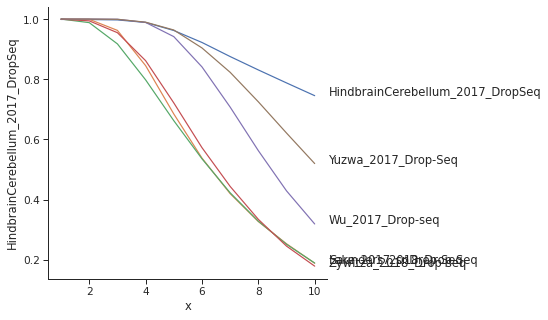

In [ ]:
sns.set(style='ticks', context='paper', font_scale=1.2)
# Create a line plot with two lines
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col, data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left')
sns.despine()
#plt.tight_layout()
plt.show()

In [ ]:
df_drop=df

### Smart-seq2

In [ ]:
sub_df['h5ad path'][sub_df.Technology=='Smart-seq2']

58     /home/huang_ziliang/project/brain/data/public/...
62     /home/huang_ziliang/project/brain/data/public/...
80     /home/huang_ziliang/project/brain/data/public/...
81     /home/huang_ziliang/project/brain/data/public/...
86             human_brain_glial_Venteicher_Smartseq2/h5
183    mouse_brain_vascular_Vanlandewijck_2018_Smart-...
193       mouse_brain_mycroglia_myeloid_Li_2018_smart/h5
194          mouse_brain_Astrocytes_Batiuk_2020_smart/h5
219    mouse_brain_NeuralCrest_Soldatov_2019_Smart-se...
Name: h5ad path, dtype: object

In [ ]:
len(f.split('/'))

10

In [ ]:
import os
smartseq_path=[]
for i in sub_df['h5ad path'][sub_df.Technology=='Smart-seq2']:
    try:
        if len(i.split('/'))<5:
            i='/home/huang_ziliang/project/brain/data/public/'+i
        files = os.listdir(i)
        smartseq_path.append(i+'/'+files[0])
        print(i+'/'+files[0])    
    except:
        pass

/home/huang_ziliang/project/brain/data/public/human_brain_Microglia_Kracht_2020_Smartseq2/h5/GSM4215042_103591-001-018-005_S5_completeCounts.h5ad
/home/huang_ziliang/project/brain/data/public/human_brain_glioma_Filbin_2018_Smartseq2/h5/meta.h5ad
/home/huang_ziliang/project/brain/data/public/human_brain_Glioblastoma_Darmanis_2017_SmartSeq2/h5/ss2_annot.h5ad
/home/huang_ziliang/project/brain/data/public/human_brain_glial_Venteicher_Smartseq2/h5/TPM_annot.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2/h5/GSE98816_Brain_samples_raw_read_counts.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_mycroglia_myeloid_Li_2018_smart/h5/mouse_brain_mycroglia_myeloid_Li_2018_smart.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_Astrocytes_Batiuk_2020_smart/h5/mouse_brain_Astrocytes_Batiuk_2020_smart.h5ad
/home/huang_ziliang/project/brain/data/public/mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2/h5/GSE129114_E8.5_who

In [ ]:
df_lst_smartseq = {}
for f in smartseq_path:
    df_lst_smartseq[f.split('/')[7]]=get_ranks(f)
    

(68, 12929) [ 3.  1. 50. ...  1.  1.  1.] /home/huang_ziliang/project/brain/data/public/human_brain_Microglia_Kracht_2020_Smartseq2/h5/GSM4215042_103591-001-018-005_S5_completeCounts.h5ad
(4058, 23686) [ 17.78   3.69 176.15 ...  17.97   5.95  16.26] /home/huang_ziliang/project/brain/data/public/human_brain_glioma_Filbin_2018_Smartseq2/h5/meta.h5ad
(3589, 23368) [  1. 291.   7. ...  26.   6. 117.] /home/huang_ziliang/project/brain/data/public/human_brain_Glioblastoma_Darmanis_2017_SmartSeq2/h5/ss2_annot.h5ad
(6341, 23686) [1.2859597e+01 1.3095481e+03 1.1200249e+00 ... 2.4004228e+02 2.6755469e+02
 2.7241213e+01] /home/huang_ziliang/project/brain/data/public/human_brain_glial_Venteicher_Smartseq2/h5/TPM_annot.h5ad
(3186, 19937) [  9. 174.   4. ... 225.  15.  64.] /home/huang_ziliang/project/brain/data/public/mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2/h5/GSE98816_Brain_samples_raw_read_counts.h5ad
(2434, 23454) [  4.  11.   2. ...  90. 256. 193.] /home/huang_ziliang/project/brain/d

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2/h5/GSE98816_Brain_samples_raw_read_counts.h5ad')

In [ ]:
df_lst_smartseq.keys()

dict_keys(['human_brain_Microglia_Kracht_2020_Smartseq2', 'human_brain_glioma_Filbin_2018_Smartseq2', 'human_brain_Glioblastoma_Darmanis_2017_SmartSeq2', 'human_brain_glial_Venteicher_Smartseq2', 'mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2', 'mouse_brain_mycroglia_myeloid_Li_2018_smart', 'mouse_brain_Astrocytes_Batiuk_2020_smart', 'mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2'])

In [ ]:
df_rate=pd.DataFrame([[sum(df_smy.cord>(i+1))/df_smy.shape[0] for i in range(10)] for df_smy in df_lst_smartseq.values()])

In [ ]:
df_rate.index=list(df_lst_smartseq.keys())

In [ ]:
df_rate

0         1  \
human_brain_Microglia_Kracht_2020_Smartseq2         1.000000  1.000000   
human_brain_glioma_Filbin_2018_Smartseq2            0.000000  0.000000   
human_brain_Glioblastoma_Darmanis_2017_SmartSeq2    1.000000  0.999721   
human_brain_glial_Venteicher_Smartseq2              0.000000  0.000000   
mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2  0.292216  0.203704   
mouse_brain_mycroglia_myeloid_Li_2018_smart         0.995070  0.992605   
mouse_brain_Astrocytes_Batiuk_2020_smart            1.000000  1.000000   
mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2    1.000000  1.000000   

                                                           2         3  \
human_brain_Microglia_Kracht_2020_Smartseq2         1.000000  1.000000   
human_brain_glioma_Filbin_2018_Smartseq2            0.000000  0.000000   
human_brain_Glioblastoma_Darmanis_2017_SmartSeq2    0.997771  0.996378   
human_brain_glial_Venteicher_Smartseq2              0.000000  0.000000   
mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2  0.166039  0.144068   
mouse_brain_mycroglia_myeloid_Li_2018_smart         0.988907  0.986442   
mouse_brain_Astrocytes_Batiuk_2020_smart            1.000000  1.000000   
mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2    0.999306  0.997917   

                                                           4         5  \
human_brain_Microglia_Kracht_2020_Smartseq2         1.000000  0.985294   
human_brain_glioma_Filbin_2018_Smartseq2            0.000000  0.000000   
human_brain_Glioblastoma_Darmanis_2017_SmartSeq2    0.993034  0.991084   
human_brain_glial_Venteicher_Smartseq2              0.000000  0.000000   
mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2  0.127119  0.118644   
mouse_brain_mycroglia_myeloid_Li_2018_smart         0.984388  0.981512   
mouse_brain_Astrocytes_Batiuk_2020_smart            1.000000  1.000000   
mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2    0.986111  0.981944   

                                                           6         7  \
human_brain_Microglia_Kracht_2020_Smartseq2         0.985294  0.985294   
human_brain_glioma_Filbin_2018_Smartseq2            0.000000  0.000000   
human_brain_Glioblastoma_Darmanis_2017_SmartSeq2    0.989412  0.988298   
human_brain_glial_Venteicher_Smartseq2              0.000000  0.000000   
mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2  0.113622  0.107972   
mouse_brain_mycroglia_myeloid_Li_2018_smart         0.981101  0.979047   
mouse_brain_Astrocytes_Batiuk_2020_smart            1.000000  1.000000   
mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2    0.979167  0.977083   

                                                           8         9  
human_brain_Microglia_Kracht_2020_Smartseq2         0.985294  0.985294  
human_brain_glioma_Filbin_2018_Smartseq2            0.000000  0.000000  
human_brain_Glioblastoma_Darmanis_2017_SmartSeq2    0.986626  0.985233  
human_brain_glial_Venteicher_Smartseq2              0.000000  0.000000  
mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2  0.104206  0.100126  
mouse_brain_mycroglia_myeloid_Li_2018_smart         0.976582  0.973295  
mouse_brain_Astrocytes_Batiuk_2020_smart            1.000000  0.998523  
mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2    0.976389  0.976389

In [ ]:
df=df_rate.T

In [ ]:
df.columns=['_'.join(s.split('_')[-3:]) for s in df_rate.index]

In [ ]:
df.shape

(10, 8)

In [ ]:
df['x']=[i+1 for i in range(10)]

In [ ]:
df

Kracht_2020_Smartseq2  Filbin_2018_Smartseq2  Darmanis_2017_SmartSeq2  \
0               1.000000                    0.0                 1.000000   
1               1.000000                    0.0                 0.999721   
2               1.000000                    0.0                 0.997771   
3               1.000000                    0.0                 0.996378   
4               1.000000                    0.0                 0.993034   
5               0.985294                    0.0                 0.991084   
6               0.985294                    0.0                 0.989412   
7               0.985294                    0.0                 0.988298   
8               0.985294                    0.0                 0.986626   
9               0.985294                    0.0                 0.985233   

   glial_Venteicher_Smartseq2  Vanlandewijck_2018_Smart-seq2  Li_2018_smart  \
0                         0.0                       0.292216       0.995070   
1                         0.0                       0.203704       0.992605   
2                         0.0                       0.166039       0.988907   
3                         0.0                       0.144068       0.986442   
4                         0.0                       0.127119       0.984388   
5                         0.0                       0.118644       0.981512   
6                         0.0                       0.113622       0.981101   
7                         0.0                       0.107972       0.979047   
8                         0.0                       0.104206       0.976582   
9                         0.0                       0.100126       0.973295   

   Batiuk_2020_smart  Soldatov_2019_Smart-seq2   x  
0           1.000000                  1.000000   1  
1           1.000000                  1.000000   2  
2           1.000000                  0.999306   3  
3           1.000000                  0.997917   4  
4           1.000000                  0.986111   5  
5           1.000000                  0.981944   6  
6           1.000000                  0.979167   7  
7           1.000000                  0.977083   8  
8           1.000000                  0.976389   9  
9           0.998523                  0.976389  10

In [ ]:
df=df[df.columns[df.iloc[9,:]>0.3]]

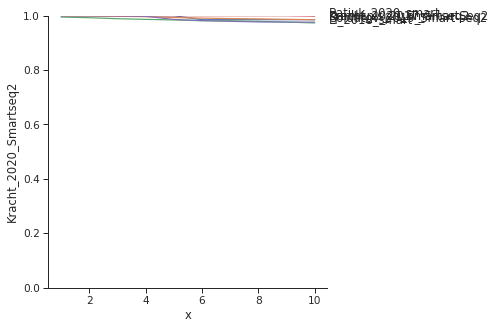

In [ ]:
figsize(5,5)
# Create a line plot with two lines
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col, data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left')
sns.despine()
plt.ylim(0,1)
plt.show()


In [ ]:
df_smart=df

### Chromium

In [ ]:
sub_df['h5ad path'][sub_df.Technology=='Chromium']

0      human_chimpanzee_bonobo_macaque_brain_Khrameev...
1      /home/huang_ziliang/project/brain/data/public/...
3                      human_brain_CNS_Marsh_2022_10x/h5
5                                              not human
6      /home/huang_ziliang/project/brain/data/public/...
                             ...                        
174         mouse_brain_hypothalamic_Huisman_2019_10x/h5
177                 mouse_brain_forebrain_Li_2020_10x/h5
180              mouse_brain_CortexHPF_Rosen_2022_10x/h5
199                     mouse_brain_Ikonomou_2020_10x/h5
204                                       \ (only mFish)
Name: h5ad path, Length: 81, dtype: object

In [ ]:
len(f.split('/'))

10

In [ ]:
import os
chromseq_path=[]
for i in sub_df['h5ad path'][sub_df.Technology=='Chromium']:
    try:
        if i.split('/')[-1]!='h5':
            print(i)
            continue
        if len(i.split('/'))<5:
            i='/home/huang_ziliang/project/brain/data/public/'+i
        files = os.listdir(i)
        chromseq_path.append(i+'/'+files[0])
        print(i+'/'+files[0])    
    except:
        pass

/home/huang_ziliang/project/brain/data/public/human_chimpanzee_bonobo_macaque_brain_Khrameeva_2020_10x/h5/GSE127774_ACC_fromSeurat.h5ad
/home/huang_ziliang/project/brain/data/public/human_brain_Microglia_Schirmer_2019_10x
/home/huang_ziliang/project/brain/data/public/human_brain_CNS_Marsh_2022_10x/h5/umap_all.h5ad
not human
/home/huang_ziliang/project/brain/data/public/human_brain_WhiteMatter_Jakel_2019_10x/h5/meta.h5ad
human_brain_microglia_midbrain_Smajic_2022_10x/h5/GSE157783_IPDCO_hg_midbrain_cell.h5ad
/home/huang_ziliang/project/brain/data/public/brain_source_Fatma_2020/h5/GSE160189_Hippo_Counts.h5
/home/huang_ziliang/project/brain/data/public/human_brain_Microglia_Tsartsalis_2021_10x/h5/meta.h5ad
/home/huang_ziliang/project/brain/data/public/human_brain_Pappalardo_TCell_2020_10x/h5/GSE155488_RAW.h5ad
/home/huang_ziliang/project/brain/data/public/human_brain_CV_SunN_2022_10x/h5/meta.h5ad
/home/huang_ziliang/project/brain/data/public/human_brain_vascular_winkler_2022_10x/h5/ImmuneA

In [ ]:
len(chromseq_path)

58

In [ ]:
1

1

In [ ]:
len(df_lst_chromseq)

24

In [ ]:
df_lst_chromseq = {}
for f in chromseq_path:
    df_lst_chromseq[f.split('/')[7]]=get_ranks(f)

(18619, 11010) [1. 1. 1. ... 1. 2. 1.] /home/huang_ziliang/project/brain/data/public/human_chimpanzee_bonobo_macaque_brain_Khrameeva_2020_10x/h5/GSE127774_ACC_fromSeurat.h5ad


/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(121278, 68308) [ 6.  3. 15. ...  1.  3.  1.] /home/huang_ziliang/project/brain/data/public/human_brain_CNS_Marsh_2022_10x/h5/umap_all.h5ad
(17799, 21581) [1. 2. 1. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/human_brain_WhiteMatter_Jakel_2019_10x/h5/meta.h5ad
(91855, 58929) [2. 1. 1. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/human_brain_Microglia_Tsartsalis_2021_10x/h5/meta.h5ad
(10032, 18133) [4.7709317 7.8931046 4.7709317 ... 5.512317  5.512317  5.512317 ] /home/huang_ziliang/project/brain/data/public/human_brain_Pappalardo_TCell_2020_10x/h5/GSE155488_RAW.h5ad
(22514, 15055) [1. 1. 1. ... 1. 2. 3.] /home/huang_ziliang/project/brain/data/public/human_brain_CV_SunN_2022_10x/h5/meta.h5ad
(55255, 39974) [ 1. 24.  1. ...  2.  1.  2.] /home/huang_ziliang/project/brain/data/public/human_brain_vascular_winkler_2022_10x/h5/ImmuneArteri_denorm_meta.h5ad


/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(690, 33694) [1. 1. 1. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/human_brain_FC_Agarwal_2020_10x/h5/GSM4157072_Sample_10_N1B.h5ad
(380610, 36527) [ 1.  2.  1. ... 24.  3.  4.] /home/huang_ziliang/project/brain/data/public/human_brain_motor_cortex_Pineda_2021_10x/h5/meta.h5ad
(76533, 50281) [1. 1. 1. ... 1. 1. 2.] /home/huang_ziliang/project/brain/data/public/human_brain_motor cortex_AllenBrain_2020_10x/h5/meta.h5ad
(166868, 36601) [1. 1. 1. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/human_brain_MTG_AllenBrain_2022_10x/h5/meta.h5ad
(33197, 33538) [1. 1. 2. ... 1. 1. 1.] /home/huang_ziliang/project/brain//data/public/human_brain_PFC_Kihara_2022_10x/h5/meta.h5ad
(39086, 29110) [4.58 4.58 4.58 ... 3.4  4.08 4.48] /home/huang_ziliang/project/brain/data/public/human_mouse_brain_source_Gaublomme_2019/h5/experiment4_human_st_lowremove_meta.h5ad


/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(15464, 33538) [1. 1. 1. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/human_brain_Frontaltemporal_Gerrits_2022_10x/h5/GSM4972278_C5A.h5ad_filtered.h5ad
(39144, 29445) [6. 2. 1. ... 3. 1. 1.] /home/huang_ziliang/project/brain/data/public/human_mouse_brain_Welch_2019_10x/h5/meta.h5ad
(45156, 19368) [0.516481   0.38646895 0.6694777  ... 1.4053127  0.8109082  0.7939301 ] /home/huang_ziliang/project/brain/data/public/human_brain_cortex_Eze_2021_10x/h5/umap_denorm.h5ad
29866 0 Series([], dtype: int64)
29867 0 Series([], dtype: int64)
29868 0 Series([], dtype: int64)
29869 0 Series([], dtype: int64)
29870 0 Series([], dtype: int64)
29871 0 Series([], dtype: int64)
29872 0 Series([], dtype: int64)
29873 0 Series([], dtype: int64)
29874 0 Series([], dtype: int64)
29875 0 Series([], dtype: int64)


/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(10631, 33538) [1. 1. 1. ... 6. 7. 3.] /home/huang_ziliang/project/brain/data/public/human_brain_fetal_Yu_2021_10x/h5/GSM5032683_GW12.h5ad
(341491, 33694) [1. 1. 1. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/brain_Bhaduri2020_Human_10x/h5/Organids.h5ad
(33943, 30779) [1. 1. 3. ... 4. 2. 1.] /home/huang_ziliang/project/brain/data/public/human_brain_organoids_Revah_2022_10x/h5/GSE190815_hCS_processed.h5ad
(17683, 15058) [-0.20141028 -0.14345226 -0.16221347 ... -0.27323246  2.2965047
 -0.4929012 ] /home/huang_ziliang/project/brain/data/public/human_brain_microglia_Xu_2020_10x/h5/GSE129178_mfy-scale-data.h5ad
(15090, 15456) [1. 1. 1. ... 1. 1. 1.] /home/huang_ziliang/project/brain/data/public/human_mouse_brain_microglia_Mancuso_2019_10x/h5/GSE137444_chimera_mouse.h5ad
(75075, 23076) [ 8.  1.  2. ... 52.  4. 42.] /home/huang_ziliang/project/brain/data/public/human_brain_GBMs_LeBlanc_2021_10x/h5/GSE173278_scRNAseq_filtered_cells_recovered.h5ad
(13574, 21085) [1. 1. 2. ... 1.

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/mouse_brain_vascular_Vanlandewijck_2018_Smart-seq2/h5/GSE98816_Brain_samples_raw_read_counts.h5ad')

In [ ]:
df_lst_chromseq.keys()

dict_keys(['human_chimpanzee_bonobo_macaque_brain_Khrameeva_2020_10x', 'human_brain_CNS_Marsh_2022_10x', 'human_brain_WhiteMatter_Jakel_2019_10x', 'human_brain_Microglia_Tsartsalis_2021_10x', 'human_brain_Pappalardo_TCell_2020_10x', 'human_brain_CV_SunN_2022_10x', 'human_brain_vascular_winkler_2022_10x', 'human_brain_FC_Agarwal_2020_10x', 'human_brain_motor_cortex_Pineda_2021_10x', 'human_brain_motor cortex_AllenBrain_2020_10x', 'human_brain_MTG_AllenBrain_2022_10x', 'public', 'human_mouse_brain_source_Gaublomme_2019', 'human_brain_Frontaltemporal_Gerrits_2022_10x', 'human_mouse_brain_Welch_2019_10x', 'human_brain_cortex_Eze_2021_10x', 'human_brain_fetal_Yu_2021_10x', 'brain_Bhaduri2020_Human_10x', 'human_brain_organoids_Revah_2022_10x', 'human_brain_microglia_Xu_2020_10x', 'human_mouse_brain_microglia_Mancuso_2019_10x', 'human_brain_GBMs_LeBlanc_2021_10x', 'human_brain_radialglia_WangR_2020_10x', 'mouse_brain_Striatum_Microglia_Badimon_2020_10x'])

In [ ]:
df_rate=pd.DataFrame([[sum(df_smy.cord>(i+1))/df_smy.shape[0] for i in range(10)] for df_smy in df_lst_chromseq.values()])

In [ ]:
df_rate.index=list(df_lst_chromseq.keys())

In [ ]:
df_rate

0         1  \
human_chimpanzee_bonobo_macaque_brain_Khrameeva...  0.998442  0.855041   
human_brain_CNS_Marsh_2022_10x                      1.000000  0.999893   
human_brain_WhiteMatter_Jakel_2019_10x              1.000000  0.999944   
human_brain_Microglia_Tsartsalis_2021_10x           1.000000  0.999978   
human_brain_Pappalardo_TCell_2020_10x               0.000000  0.000000   
human_brain_CV_SunN_2022_10x                        1.000000  1.000000   
human_brain_vascular_winkler_2022_10x               1.000000  1.000000   
human_brain_FC_Agarwal_2020_10x                     1.000000  1.000000   
human_brain_motor_cortex_Pineda_2021_10x            1.000000  1.000000   
human_brain_motor cortex_AllenBrain_2020_10x        1.000000  1.000000   
human_brain_MTG_AllenBrain_2022_10x                 0.999994  0.999407   
public                                              1.000000  1.000000   
human_mouse_brain_source_Gaublomme_2019             0.000026  0.000000   
human_brain_Frontaltemporal_Gerrits_2022_10x        1.000000  0.998448   
human_mouse_brain_Welch_2019_10x                    1.000000  1.000000   
human_brain_cortex_Eze_2021_10x                     0.000000  0.000000   
human_brain_fetal_Yu_2021_10x                       1.000000  1.000000   
brain_Bhaduri2020_Human_10x                         1.000000  0.999988   
human_brain_organoids_Revah_2022_10x                1.000000  1.000000   
human_brain_microglia_Xu_2020_10x                   0.000000  0.000000   
human_mouse_brain_microglia_Mancuso_2019_10x        1.000000  0.999867   
human_brain_GBMs_LeBlanc_2021_10x                   0.715178  0.593380   
human_brain_radialglia_WangR_2020_10x               1.000000  0.999705   
mouse_brain_Striatum_Microglia_Badimon_2020_10x     0.115854  0.032566   

                                                           2         3  \
human_chimpanzee_bonobo_macaque_brain_Khrameeva...  0.549009  0.298083   
human_brain_CNS_Marsh_2022_10x                      0.996042  0.978735   
human_brain_WhiteMatter_Jakel_2019_10x              0.992247  0.950559   
human_brain_Microglia_Tsartsalis_2021_10x           0.999173  0.993631   
human_brain_Pappalardo_TCell_2020_10x               0.000000  0.000000   
human_brain_CV_SunN_2022_10x                        0.999423  0.989340   
human_brain_vascular_winkler_2022_10x               1.000000  1.000000   
human_brain_FC_Agarwal_2020_10x                     0.997101  0.986957   
human_brain_motor_cortex_Pineda_2021_10x            0.999777  0.998311   
human_brain_motor cortex_AllenBrain_2020_10x        0.999987  0.999909   
human_brain_MTG_AllenBrain_2022_10x                 0.995164  0.987541   
public                                              0.999367  0.995451   
human_mouse_brain_source_Gaublomme_2019             0.000000  0.000000   
human_brain_Frontaltemporal_Gerrits_2022_10x        0.984868  0.953440   
human_mouse_brain_Welch_2019_10x                    1.000000  0.999029   
human_brain_cortex_Eze_2021_10x                     0.000000  0.000000   
human_brain_fetal_Yu_2021_10x                       0.999718  0.998119   
brain_Bhaduri2020_Human_10x                         0.997672  0.981127   
human_brain_organoids_Revah_2022_10x                0.999941  0.997201   
human_brain_microglia_Xu_2020_10x                   0.000000  0.000000   
human_mouse_brain_microglia_Mancuso_2019_10x        0.999072  0.996620   
human_brain_GBMs_LeBlanc_2021_10x                   0.479121  0.401891   
human_brain_radialglia_WangR_2020_10x               0.997053  0.989907   
mouse_brain_Striatum_Microglia_Badimon_2020_10x     0.028024  0.025803   

                                                           4         5  \
human_chimpanzee_bonobo_macaque_brain_Khrameeva...  0.153231  0.071594   
human_brain_CNS_Marsh_2022_10x                      0.941787  0.887449   
human_brain_WhiteMatter_Jakel_2019_10x              0.862914  0.734255   
human_brain_Microglia_Tsartsalis_2021_10x           0.981024 

In [ ]:
df=df_rate.T

In [ ]:
df.columns=['_'.join(s.split('_')[-3:]) for s in df_rate.index]

In [ ]:
df.shape

(10, 24)

In [ ]:
df['x']=[i+1 for i in range(10)]

In [ ]:
df

Khrameeva_2020_10x  Marsh_2022_10x  Jakel_2019_10x  Tsartsalis_2021_10x  \
0            0.998442        1.000000        1.000000             1.000000   
1            0.855041        0.999893        0.999944             0.999978   
2            0.549009        0.996042        0.992247             0.999173   
3            0.298083        0.978735        0.950559             0.993631   
4            0.153231        0.941787        0.862914             0.981024   
5            0.071594        0.887449        0.734255             0.963911   
6            0.037113        0.819060        0.601157             0.943835   
7            0.018637        0.740291        0.479521             0.919743   
8            0.010419        0.656574        0.377381             0.892973   
9            0.004887        0.575018        0.297489             0.862718   

   TCell_2020_10x  SunN_2022_10x  winkler_2022_10x  Agarwal_2020_10x  \
0             0.0       1.000000          1.000000          1.000000   
1             0.0       1.000000          1.000000          1.000000   
2             0.0       0.999423          1.000000          0.997101   
3             0.0       0.989340          1.000000          0.986957   
4             0.0       0.962468          1.000000          0.950725   
5             0.0       0.920005          0.999964          0.859420   
6             0.0       0.863596          0.999747          0.768116   
7             0.0       0.796260          0.999294          0.672464   
8             0.0       0.722528          0.997702          0.553623   
9             0.0       0.645776          0.993340          0.443478   

   Pineda_2021_10x  AllenBrain_2020_10x  ...  Eze_2021_10x  Yu_2021_10x  \
0         1.000000             1.000000  ...           0.0     1.000000   
1         1.000000             1.000000  ...           0.0     1.000000   
2         0.999777             0.999987  ...           0.0     0.999718   
3         0.998311             0.999909  ...           0.0     0.998119   
4         0.994624             0.999686  ...           0.0     0.986925   
5         0.986853             0.998994  ...           0.0     0.949675   
6         0.973164             0.997857  ...           0.0     0.888157   
7         0.950716             0.996185  ...           0.0     0.815351   
8         0.917096             0.993519  ...           0.0     0.748001   
9         0.873261             0.989678  ...           0.0     0.690340   

   Bhaduri2020_Human_10x  Revah_2022_10x  Xu_2020_10x  Mancuso_2019_10x  \
0               1.000000        1.000000          0.0          1.000000   
1               0.999988        1.000000          0.0          0.999867   
2               0.997672        0.999941          0.0          0.999072   
3               0.981127        0.997201          0.0          0.996620   
4               0.937225        0.979377          0.0          0.989463   
5               0.868380        0.929352          0.0          0.975348   
6               0.790891        0.849954          0.0          0.954274   
7               0.717310        0.747577          0.0          0.918754   
8               0.654149        0.638600          0.0          0.863685   
9               0.598994        0.533689          0.0          0.782107   

   LeBlanc_2021_10x  WangR_2020_10x  Badimon_2020_10x   x  
0          0.715178        1.000000          0.115854   1  
1          0.593380        0.999705          0.032566   2  
2          0.479121        0.997053          0.028024   3  
3          0.401891        0.989907          0.025803   4  
4          0.337769        0.979520          0.022816   5  
5          0.281971        0.966922          0.019841   6  
6          0.219780        0.948210          0.017520   7  
7          0.196697        0.931781          0.015825   8  
8          0.180500        0.912701          0.014641   9  
9          0.166833        0.894062          0.013728  10  

[10 rows x 25 columns]

In [ ]:
df=df[df.columns[df.iloc[9,:]>0.3]]

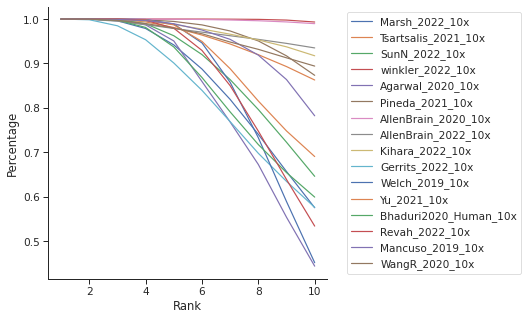

In [ ]:
# Create a line plot with two lines
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col, data=df,label=col)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    #plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left',fontsize=8)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Percentage')
plt.xlabel('Rank')
plt.show()


In [ ]:
df_chrom=df

In [ ]:
df_chrom.columns=['Marsh_2022_10x', 'Tsartsalis_2021_10x', 'SunN_2022_10x',
       'winkler_2022_10x', 'Agarwal_2020_10x', 'Pineda_2021_10x',
       'AllenBrain_2020_10x', 'AllenBrain_2022_10x', 'Kihara_2022_10x',
       'Gerrits_2022_10x', 'Welch_2019_10x', 'Yu_2021_10x',
       'Bhaduri2020_Human_10x', 'Revah_2022_10x', 'Mancuso_2019_10x',
       'WangR_2020_10x', 'x']

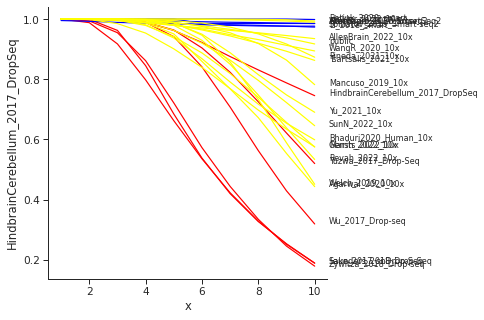

In [ ]:
df=df_drop
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col,color='red', data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left',fontsize=8)
df=df_smart
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col,color='blue', data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left',fontsize=8)
df=df_chrom
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col,color='yellow', data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left',fontsize=8)
sns.despine()
plt.show()


In [ ]:
df_mean = pd.concat([df_drop.iloc[:, :-1].mean(axis=1),
                    df_smart.iloc[:, :-1].mean(axis=1),
                    df_chrom.iloc[:, :-1].mean(axis=1),
                    df_drop.iloc[:, -1]], axis=1)

In [ ]:
df_mean.columns=['Drop-seq','Smart-seq2','Chromium','Rank']

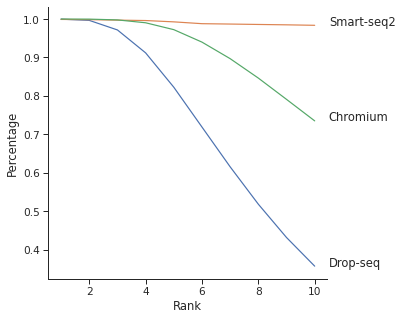

<Figure size 360x360 with 0 Axes>

In [ ]:
df=df_mean
sns.set(style='ticks', context='paper', font_scale=1.2)
for col in df.columns[:-1]:
    sns.lineplot(x='Rank', y=col, data=df)

    # Get the last x and y values of the line
    x_last = df['Rank'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left')
sns.despine()
plt.ylabel('Percentage')
plt.show()
plt.savefig('figures/The_top10_count_and_rank_consistency.pdf')

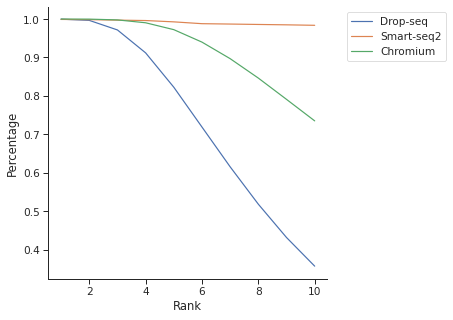

In [ ]:
df=df_mean
# Create a line plot with two lines
for col in df.columns[:-1]:
    sns.lineplot(x='Rank', y=col, data=df,label=col)

    # Get the last x and y values of the line
    x_last = df['Rank'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    #plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left',fontsize=8)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Percentage')
plt.xlabel('Rank')
plt.show()


In [ ]:
df1=df_drop.iloc[:5,:-1]
df1['Rank']=[str(i+1) for i in range(5)]
df1['Tech']='Drop-seq'
df1=pd.lreshape(df1, {'Sample': list(df1.columns[:-2])})

df2=df_smart.iloc[:5,:-1]
df2['Rank']=[str(i+1) for i in range(5)]
df2['Tech']='Smart-seq2'
df2=pd.lreshape(df2, {'Sample': list(df2.columns[:-2])})

df3=df_chrom.iloc[:5,:-1]
df3['Rank']=[str(i+1) for i in range(5)]
df3['Tech']='Chromium'
df3=pd.lreshape(df3, {'Sample': list(df3.columns[:-2])})
df = pd.concat([df3, df2, df1], axis=0)

In [ ]:
df

Rank      Tech    Sample
0     1  Chromium  1.000000
1     2  Chromium  0.999893
2     3  Chromium  0.996042
3     4  Chromium  0.978735
4     5  Chromium  0.941787
..  ...       ...       ...
25    1  Drop-seq  1.000000
26    2  Drop-seq  1.000000
27    3  Drop-seq  0.999061
28    4  Drop-seq  0.989671
29    5  Drop-seq  0.963693

[135 rows x 3 columns]

<AxesSubplot:xlabel='Tech', ylabel='Sample'>

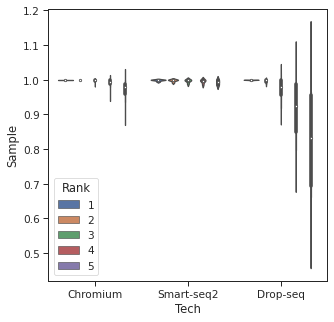

In [ ]:
sns.violinplot(x='Tech', y='Sample', hue='Rank', data=df)

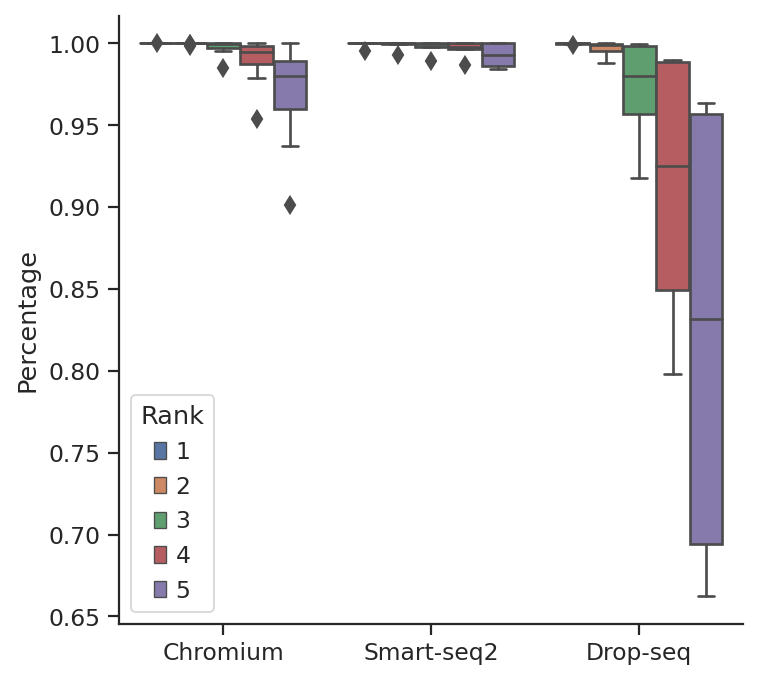

In [ ]:
sns.set(style='ticks', context='paper', font_scale=1.2)
sns.boxplot(x='Tech', y='Sample', hue='Rank', data=df)
sns.despine()
plt.ylabel('Percentage')
plt.xlabel('')
plt.show()
#plt.savefig('figures/The_top10_count_and_rank_consistency.pdf')

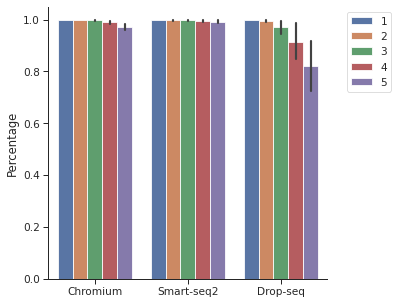

In [ ]:
sns.set(style='ticks', context='paper', font_scale=1.2)
sns.barplot(x='Tech', y='Sample', hue='Rank', data=df)
sns.despine()
plt.ylabel('Percentage')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
#plt.savefig('figures/The_top10_count_and_rank_consistency.pdf')

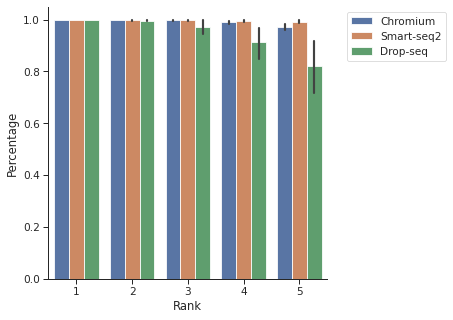

In [ ]:
sns.set(style='ticks', context='paper', font_scale=1.2)
sns.barplot(x='Rank', y='Sample', hue='Tech', data=df)
sns.despine()
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
#plt.savefig('figures/The_top10_count_and_rank_consistency.pdf')

# 1.Save as pickle

In [ ]:
tmp=[df_mean,df_smart,df_drop,df_chrom,df_lst_smartseq,df_lst_dropseq,df_lst_chromseq]
with open('data/results/figure1_results.pickle', 'wb') as handle:
    pickle.dump(tmp, handle, protocol=pickle.HIGHEST_PROTOCOL)

### load and plot

In [ ]:
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)

In [6]:
with open('data/results/figure1_results.pickle', 'rb') as handle:
    df_mean,df_smart,df_drop,df_chrom,df_lst_smartseq,df_lst_dropseq,df_lst_chromseq=pickle.load(handle)

In [7]:
len(df_lst_smartseq)

8

In [8]:
len(df_lst_dropseq)

7

In [9]:
len(df_lst_chromseq)

24

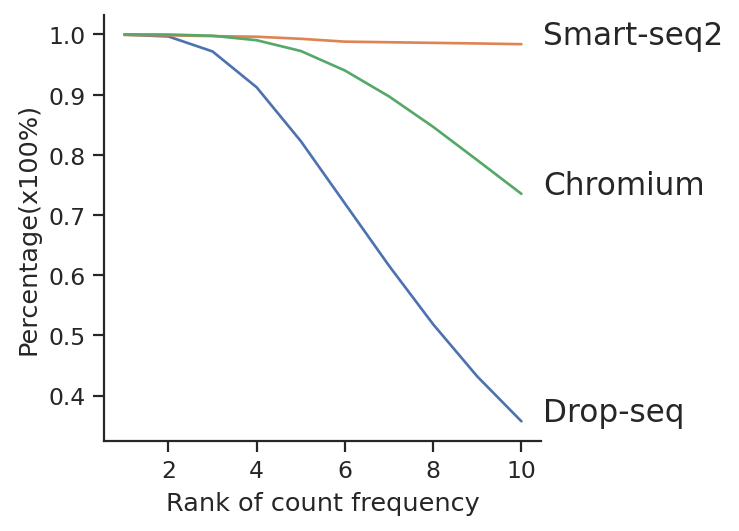

In [ ]:
figsize(3.5,3.5)
df=df_mean
for col in df.columns[:-1]:
    sns.lineplot(x='Rank', y=col, data=df)

    # Get the last x and y values of the line
    x_last = df['Rank'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left',fontsize=14)
sns.despine()
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
plt.grid(visible=False)
plt.ylabel('Percentage(x100%)')#, fontsize=18)
plt.xlabel('Rank of count frequency')#, fontsize=18)
plt.savefig('figures/The_top10_count_and_rank_consistency.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
df1=df_drop.iloc[:5,:-1]
df1['Rank']=[str(i+1) for i in range(5)]
df1['Tech']='Drop-seq'
df1=pd.lreshape(df1, {'Sample': list(df1.columns[:-2])})

df2=df_smart.iloc[:5,:-1]
df2['Rank']=[str(i+1) for i in range(5)]
df2['Tech']='Smart-seq2'
df2=pd.lreshape(df2, {'Sample': list(df2.columns[:-2])})

df3=df_chrom.iloc[:5,:-1]
df3['Rank']=[str(i+1) for i in range(5)]
df3['Tech']='Chromium'
df3=pd.lreshape(df3, {'Sample': list(df3.columns[:-2])})
df = pd.concat([df3, df2, df1], axis=0)

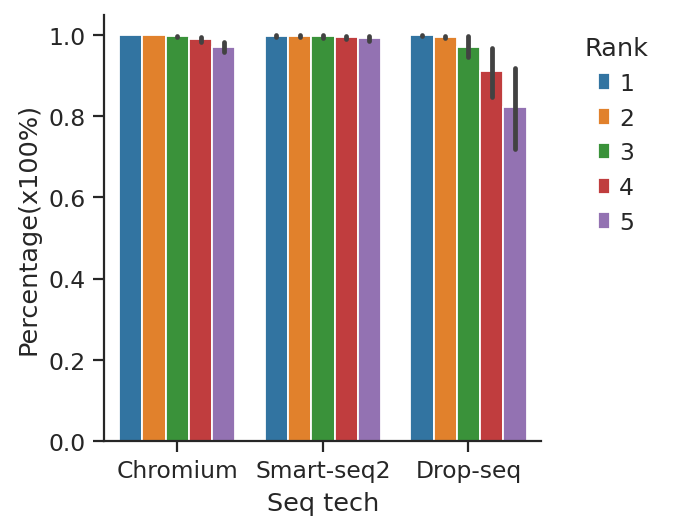

In [ ]:
sns.barplot(x='Tech', y='Sample', hue='Rank', data=df,palette=[cmap(i) for i in range(5)])
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title='Rank',frameon=False)
plt.grid(visible=False)
plt.ylabel('Percentage(x100%)')#, fontsize=18)
plt.xlabel('Seq tech')#, fontsize=18)
plt.savefig('figures/The_top5_count_and_rank_consistency.pdf',dpi=300, bbox_inches='tight',transparent=True)

Text(0.5, 0, 'Seq tech')

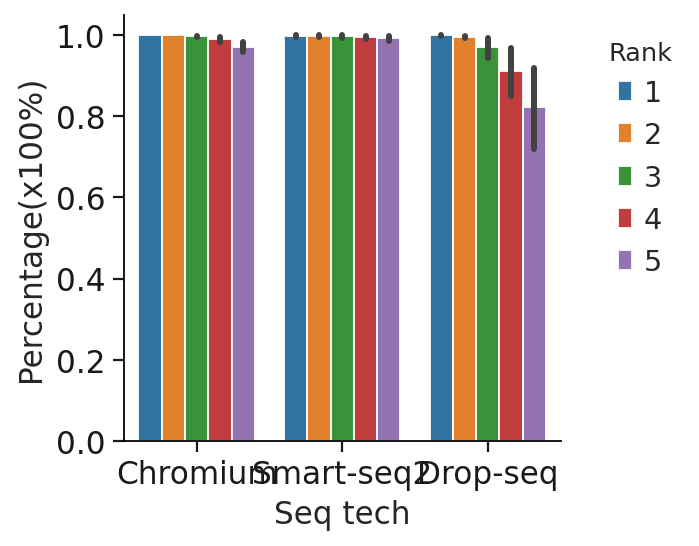

In [ ]:
#figsize(3.5,3.5)
sns.barplot(x='Tech', y='Sample', hue='Rank', data=df,palette=[cmap(i) for i in range(5)])
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title='Rank',frameon=False)
plt.grid(visible=False)
plt.ylabel('Percentage(x100%)')#, fontsize=18)
plt.xlabel('Seq tech')#, fontsize=18)
#plt.savefig('figures/The_top5_count_and_rank_consistency.pdf',dpi=300, bbox_inches='tight',transparent=True)

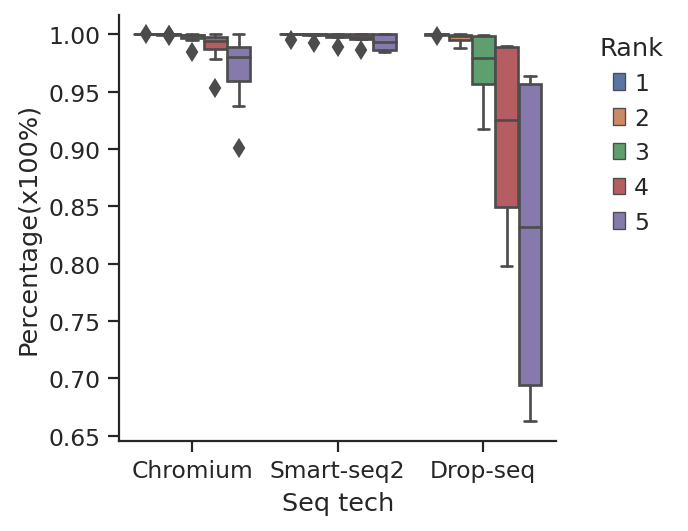

In [ ]:
figsize(3.5,3.5)
sns.set(style='ticks', context='paper', font_scale=1.2)
sns.boxplot(x='Tech', y='Sample', hue='Rank', data=df)
sns.despine()
plt.ylabel('Percentage(x100%)')#, fontsize=18)
plt.xlabel('Seq tech')#, fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title='Rank',frameon=False)
plt.show()
#plt.savefig('figures/The_top10_count_and_rank_consistency.pdf')

## Seq-depth (maybe late)

# 2. Auto detect base and pseudo count
- The error of regression (MSE of loss, base, and pseudo count distribution) in different base (e,2,10) and pseudo (0.01,0.1,1)

In [ ]:
ad=sc.datasets.pbmc3k()

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq/h5/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq.h5ad')

In [ ]:
smtx = ad.copy().X.tocsr().asfptype()
sc.pp.normalize_total(ad, target_sum=1e4)
smtx1 = ad.copy().X.tocsr().asfptype()
sc.pp.log1p(ad)
smtx2 = ad.copy().X.tocsr().asfptype()

In [ ]:
smtx.shape[0]

13214

In [ ]:
def solve_bc(p,y1,y2):
    return sum((np.power(p[0],y2)-2*np.power(p[0],y1)+p[1])**2)

In [ ]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [ ]:
def auto_detect_error(ad,base,pseudo,total,num=10,seed=0):
    np.random.seed(seed)
    #normalization
    ad=ad.copy()
    sc.pp.normalize_total(ad, target_sum=total)
    smtx2=ad.X
    smtx2.data=np.log(smtx2.data+pseudo)/np.log(base)
    print(smtx2.data)
    #minimize
    ress=[]
    for _ in range(num):
        ys=[]
        for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
            try:
                c = pd.Series(smtx2.getrow(c_idx).data)
                y = np.array(c.value_counts().sort_index().head(2).index)
                ys.append(y)
            except:
                print(c_idx)
        ys=np.array(ys)
        y1=ys[:,0]
        y2=ys[:,1]
        res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
        ress.append([res.x[0],res.x[1],res.fun])
    return pd.DataFrame(ress,columns=['base','pseudo','loss'])

In [ ]:
res_2_1_4=auto_detect_error(ad,base=2,pseudo=1,total=1e4,num=100,seed=0)

In [ ]:
res_all=[]
for b in [np.e,2,10]:
    for p in [0.01,0.1,1]:
        for t in [1e4,1e5,1e6]:
            res_all.append(auto_detect_error(ad,base=b,pseudo=p,total=t,num=10,seed=0))

[1.4208226 1.4208226 2.1127615 ... 1.6189492 1.6189492 2.71624  ]
[3.7212315 3.7212315 4.4142575 ... 3.9197497 3.9197497 5.0182295]
[6.0235987 6.0235987 6.716734  ... 6.222156  6.222156  7.3207555]
[1.442326  1.442326  2.123584  ... 1.6366217 1.6366217 2.7221735]
[3.7234075 3.7234075 4.4153466 ... 3.9215343 3.9215343 5.018825 ]
[6.0238166 6.0238166 6.7168427 ... 6.222335  6.222335  7.320815 ]
[1.6352079 1.6352079 2.2258174 ... 1.7980369 1.7980369 2.779648 ]
[3.7449112 3.7449112 4.426169  ... 3.9392068 3.9392068 5.0247583]
[6.025993  6.025993  6.7179317 ... 6.2241197 6.2241197 7.32141  ]
[2.0498137 2.0498137 3.0480704 ... 2.33565   2.33565   3.918706 ]
[5.3686023 5.3686023 6.3684273 ... 5.6550035 5.6550035 7.2397747]
[ 8.690216  8.690216  9.690199 ...  8.976674  8.976674 10.561618]
[2.0808365 2.0808365 3.0636842 ... 2.361146  2.361146  3.9272661]
[5.3717413 5.3717413 6.3699985 ... 5.657578  5.657578  7.240634 ]
[ 8.69053   8.69053   9.690355 ...  8.976932  8.976932 10.561704]
[2.3591063

In [ ]:
res_all

[       base    pseudo          loss
 0  2.718282  0.009999  1.141435e-10
 1  2.718282  0.009999  8.536837e-11
 2  2.718282  0.010000  1.248238e-10
 3  2.718282  0.010000  9.481819e-11
 4  2.718282  0.010000  6.140580e-11
 5  2.718282  0.010000  1.089808e-10
 6  2.718282  0.010000  1.020955e-10
 7  2.718282  0.010000  1.418810e-10
 8  2.718282  0.010000  8.616569e-11
 9  2.718282  0.009999  7.983506e-11,
        base    pseudo          loss
 0  2.718281  0.010012  4.021277e-08
 1  2.718282  0.009994  4.189311e-08
 2  2.718282  0.009998  8.850467e-08
 3  2.718282  0.010000  5.240987e-08
 4  2.718282  0.009991  3.087073e-08
 5  2.718282  0.009991  5.630571e-08
 6  2.718283  0.009977  3.492867e-08
 7  2.718281  0.010012  7.282743e-08
 8  2.718283  0.009977  3.751202e-08
 9  2.718282  0.009995  5.595355e-08,
        base    pseudo      loss
 0  2.718282  0.009982  0.000009
 1  2.718282  0.010028  0.000004
 2  2.718282  0.010008  0.000009
 3  2.718282  0.010043  0.000005
 4  2.718282  0.010

In [ ]:
def f1(p, x, y):
    a = np.exp(p[0])
    b = p[1]
    c = np.exp(p[2])
    u = np.log(a*x+c)/np.log(b)
    return np.sum((u-y)**2)

def grad_f1(p, x, y):
    a = np.exp(p[0])
    b = p[1]
    c = np.exp(p[2])
    dx = a*x + c
    u = np.log(dx) / np.log(b)
    dudx = a/(dx*np.log(b))
    dudb = -np.log(dx)*(u-y)/(np.log(b)**2)
    dudc = 1/(dx*np.log(b))
    grad_u = np.array([dudx, dudb, dudc])
    return 2*np.sum(grad_u*(u-y), axis=1)

bounds = [(None, None), (1.9, None), (None, None)]
res = minimize(f1, [0, 2.7, 0], method='L-BFGS-B', tol=1e-6, bounds=bounds, jac=grad_f1, args=(x, y))

In [ ]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.003952933025822436
        x: [ 5.211e+00  2.403e+00  2.591e+00]
      nit: 14
      jac: [-1.477e-03 -5.288e-03  2.190e-03]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [ ]:
def f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    return np.sum((u-y)**2)

def grad_f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    dudx = p[0]/((p[0]*x+p[2])*np.log(p[1]))
    dudp = 1/np.log(p[1])
    grad_u = np.vstack((dudx, np.zeros_like(p[1:]), dudp))
    return 2*np.sum(grad_u*(u-y), axis=1)
bounds = [(1e-6, None), (1.9, None), (1e-6, None)]
#res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-6, bounds=bounds, args=(x, y))

In [ ]:
ress=[]
for c_idx in range(10):
    N = 5
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [10,20,1], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[13.1577773   2.71827622  1.00004102] 1.7224308437417377e-13 1.7224308437417377e-13 True
[13.88883188  2.71827944  1.00002249] 1.3560821197761832e-13 1.3560821197761832e-13 True
[8.27124629 2.71827758 1.00002189] 2.322690871762918e-13 2.322690871762918e-13 True
[10.81071476  2.71827616  1.00003784] 3.1095779177253787e-13 3.1095779177253787e-13 True
[17.79343138  2.71827662  1.00005918] 3.380794670194479e-13 3.380794670194479e-13 True
[4.55457301 1.9        3.90293864] 0.03799356142630529 0.03799356142630529 True
[17.0646893   2.71827651  1.00005896] 3.3507742795854773e-13 3.3507742795854773e-13 True
[21.1416199   2.71828114  1.00001198] 1.7994490832082687e-13 1.7994490832082687e-13 True
[15.12849407  2.71827805  1.00003675] 3.317084660901845e-13 3.317084660901845e-13 True
[23.09438912  2.71827478  1.00010534] 5.721111317542186e-13 5.721111317542186e-13 True


In [ ]:
ress=[]
for c_idx in range(10):
    N = 4
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [10,20,1], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[13.94260384  2.75479772  0.71316284] 5.507176079070093e-06 5.507176079070093e-06 True
[13.88869979  2.71827335  1.00006162] 2.8469659732694833e-13 2.8469659732694833e-13 True
[8.27129534 2.71828134 0.99999833] 6.553440650845756e-14 6.553440650845756e-14 True
[10.80970476  2.7182177   1.00041892] 5.041789932835735e-11 5.041789932835735e-11 True
[17.79337637  2.71827417  1.00004693] 1.1197926063944086e-12 1.1197926063944086e-12 True
[27.24728218  2.7182685   1.00021554] 7.069350669740378e-13 7.069350669740378e-13 True
[17.06454959  2.71827141  1.00010064] 4.3347507081004946e-13 4.3347507081004946e-13 True
[21.14138599  2.7182746   1.000092  ] 4.941416826444322e-13 4.941416826444322e-13 True
[15.12839045  2.71827362  1.00006909] 3.348602255490489e-13 3.348602255490489e-13 True
[23.09424449  2.71827108  1.00014364] 5.320705689205696e-13 5.320705689205696e-13 True


In [ ]:
ress=[]
for c_idx in range(10):
    N = 3
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [10,20,1], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[13.14390607  2.71759332  1.0045714 ] 5.778358492176707e-10 5.778358492176707e-10 True
[13.28654912  2.69011716  1.19304346] 9.986402938639353e-07 9.986402938639353e-07 True
[8.27171039 2.71831839 0.99986151] 1.8635485260228024e-12 1.8635485260228024e-12 True
[10.81054084  2.71826485  1.00009011] 3.9828140587620675e-13 3.9828140587620675e-13 True
[17.7930231   2.71826259  1.00018352] 5.087388982658493e-13 5.087388982658493e-13 True
[27.24640869  2.71825004  1.00043741] 1.1956084426874002e-12 1.1956084426874002e-12 True
[17.06520841  2.71829414  0.99989339] 3.638104243644887e-12 3.638104243644887e-12 True
[21.14100814  2.71826392  1.0001915 ] 3.865120568127607e-13 3.865120568127607e-13 True
[10.17552316  2.49896923  2.719958  ] 0.00048669630092507225 0.00048669630092507225 True
[23.09415608  2.71826877  1.0001652 ] 4.999566617505669e-13 4.999566617505669e-13 True


## scaling factor of violin plot for multiple dataset with different seq-tech

In [ ]:
tmp=pd.Series([10000/(smtx.getrow(i).data.sum()) for i in range(smtx.shape[0])])

<AxesSubplot:>

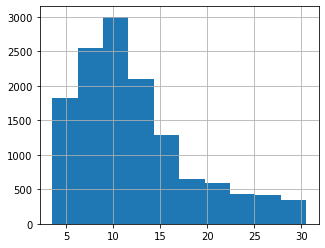

In [ ]:
tmp.hist()

In [ ]:
df=[]
cmax=[]
for c_idx in range(smtx.shape[0]):
    N = 10
    c = pd.Series(smtx.getrow(c_idx).data)
    c=c.value_counts().sort_index()
    cmax.append(c.index[-1])
    try:
        df.append((c.index==(np.arange(0, c.shape[0])+1)))
    except:
        print(c_idx,len(c))

In [ ]:
df_smy=pd.DataFrame([[x.sum(),x.shape[0]] for x in df])

In [ ]:
df_smy.columns=['cord','clen']
df_smy['cmax']=cmax

In [ ]:
df_smy

cord  clen   cmax
0         6    10   45.0
1         7     9   64.0
2         6    11  134.0
3         6    10  103.0
4         5     7   22.0
...     ...   ...    ...
13209     4     8   16.0
13210     5     6    7.0
13211     3     5   15.0
13212     6    11   46.0
13213     3     8   10.0

[13214 rows x 3 columns]

In [ ]:
cord_rate=[sum(df_smy.cord>(i+1))/df_smy.shape[0] for i in range(10)]

In [ ]:
cord_rate

[1.0,
 0.9976540033298017,
 0.9688966247918874,
 0.8792946874527017,
 0.7309671560466172,
 0.5575904343877706,
 0.3939004086574845,
 0.2599515665203572,
 0.16361434841834419,
 0.09777508702890873]

In [ ]:
ad.X=sparse.csc_array(ad.X)

In [ ]:
def get_ranks(file):
    ad=sc.read(file)
    if not sparse.issparse(ad.X):
        ad.X=sparse.csc_array(ad.X)
    print(ad.shape,ad.X.data,file)
    smtx = ad.X.tocsr().asfptype()
    df=[]
    cmax=[]
    for c_idx in range(smtx.shape[0]):
        c = pd.Series(smtx.getrow(c_idx).data)
        c=c.value_counts().sort_index()
        try:
            cmax.append(c.index[-1])
            df.append((c.index==(np.arange(0, c.shape[0])+1)))
        except:
            print(c_idx,len(c),c)

    df_smy=pd.DataFrame([[x.sum(),x.shape[0]] for x in df])
    df_smy.columns=['cord','clen']
    df_smy['cmax']=cmax
    return df_smy

In [ ]:
df_lst = [get_ranks(f) for f in h5_benchmark]

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
df_rate=pd.DataFrame([[sum(df_smy.cord>(i+1))/df_smy.shape[0] for i in range(10)] for df_smy in df_lst])

In [ ]:
df_rate.index=[s.split('/')[7] for s in h5_benchmark]

In [ ]:
s=h5_benchmark[0].split('/')[7].split('_')

In [ ]:
'_'.join(s[-3:])

'Fiorenzano_2021_10x'

In [ ]:
df_rate

0         1  \
human_brain_organoids_Fiorenzano_2021_10x           1.000000  0.999870   
human_mouse_brain_Welch_2019_10x                    1.000000  1.000000   
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  1.000000  0.999591   
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.999546  0.995917   
mouse_brain_lateral_hypothalamic_area_Mickelsen...  1.000000  1.000000   
mouse_brain_choroid_plexus_Dani_2021_10x            0.999787  0.997871   
human_brain_entorhinalcortex_Grubman_2019_DroNc...  1.000000  0.997654   
mouse_brain_developing_ZhangX_2022_10x              1.000000  0.997455   
human_mouse_brain_Chen_2019_SNARE-seq               1.000000  0.990838   
mouse_brain_Hippocampal_Mirabella_2021_10x          1.000000  1.000000   

                                                           2         3  \
human_brain_organoids_Fiorenzano_2021_10x           0.998921  0.997210   
human_mouse_brain_Welch_2019_10x                    1.000000  0.998477   
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  0.994111  0.972698   
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.965426  0.878947   
mouse_brain_lateral_hypothalamic_area_Mickelsen...  0.999862  0.999032   
mouse_brain_choroid_plexus_Dani_2021_10x            0.983874  0.951267   
human_brain_entorhinalcortex_Grubman_2019_DroNc...  0.968897  0.879295   
mouse_brain_developing_ZhangX_2022_10x              0.949473  0.837514   
human_mouse_brain_Chen_2019_SNARE-seq               0.906043  0.771020   
mouse_brain_Hippocampal_Mirabella_2021_10x          0.997787  0.989491   

                                                           4         5  \
human_brain_organoids_Fiorenzano_2021_10x           0.993333  0.986406   
human_mouse_brain_Welch_2019_10x                    0.984987  0.921889   
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  0.929702  0.869515   
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.734936  0.569601   
mouse_brain_lateral_hypothalamic_area_Mickelsen...  0.997511  0.993363   
mouse_brain_choroid_plexus_Dani_2021_10x            0.911758  0.869065   
human_brain_entorhinalcortex_Grubman_2019_DroNc...  0.730967  0.557590   
mouse_brain_developing_ZhangX_2022_10x              0.670302  0.499455   
human_mouse_brain_Chen_2019_SNARE-seq               0.646199  0.530409   
mouse_brain_Hippocampal_Mirabella_2021_10x          0.973142  0.953844   

                                                           6         7  \
human_brain_organoids_Fiorenzano_2021_10x           0.976017  0.962520   
human_mouse_brain_Welch_2019_10x                    0.800479  0.635988   
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  0.797072  0.718502   
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.418875  0.297459   
mouse_brain_lateral_hypothalamic_area_Mickelsen...  0.979812  0.950221   
mouse_brain_choroid_plexus_Dani_2021_10x            0.818620  0.756213   
human_brain_entorhinalcortex_Grubman_2019_DroNc...  0.393900  0.259952   
mouse_brain_developing_ZhangX_2022_10x              0.370047  0.287532   
human_mouse_brain_Chen_2019_SNARE-seq               0.434113  0.350097   
mouse_brain_Hippocampal_Mirabella_2021_10x          0.934976  0.920349   

                                                           8         9  
human_brain_organoids_Fiorenzano_2021_10x           0.946697  0.929753  
human_mouse_brain_Welch_2019_10x                    0.456919  0.299608  
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  0.641055  0.570928  
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.209800  0.145735  
mouse_brain_lateral_hypothalamic_area_Mickelsen...  0.906803  0.853982  
mouse_brain_choroid_plexus_Dani_2021_10x            0.681198  0.595642  
human_brain_entorhinalcortex_Grubman_2019_DroNc...  0.163614  0.097775  
mouse_brain_developing_ZhangX_2022_10x              0.225373  0.179935  
human_mouse_brain_Chen_2019_SNARE-seq               0.276283  0.211371  
mouse_brain_Hippocampal_Mirabella_2021_10x          0.909471  0.90037

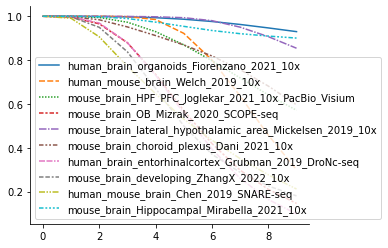

In [ ]:
figsize(5,4)
sns.lineplot(data=df_rate.T)
sns.despine()
#plt.legend().remove()
#plt.xticks(ticks=list(range(0,len(tmp1),2)))
plt.show()

In [ ]:
['_'.join(s.split('/')[7].split('_')[-3:]) for s in h5_benchmark]

['Fiorenzano_2021_10x',
 'Welch_2019_10x',
 '10x_PacBio_Visium',
 'Mizrak_2020_SCOPE-seq',
 'Mickelsen_2019_10x',
 'Dani_2021_10x',
 'Grubman_2019_DroNc-seq',
 'ZhangX_2022_10x',
 'Chen_2019_SNARE-seq',
 'Mirabella_2021_10x']

In [ ]:
df=df_rate.T

In [ ]:
df.columns=['Fiorenzano_2021_10x',
 'Welch_2019_10x',
 'Joglekar_2021_10x',
 'Mizrak_2020_SCOPE-seq',
 'Mickelsen_2019_10x',
 'Dani_2021_10x',
 'Grubman_2019_DroNc-seq',
 'ZhangX_2022_10x',
 'Chen_2019_SNARE-seq',
 'Mirabella_2021_10x']

In [ ]:
df['x']=[i+1 for i in range(10)]

In [ ]:
df

Fiorenzano_2021_10x  Welch_2019_10x  Joglekar_2021_10x  \
0             1.000000        1.000000           1.000000   
1             0.999870        1.000000           0.999591   
2             0.998921        1.000000           0.994111   
3             0.997210        0.998477           0.972698   
4             0.993333        0.984987           0.929702   
5             0.986406        0.921889           0.869515   
6             0.976017        0.800479           0.797072   
7             0.962520        0.635988           0.718502   
8             0.946697        0.456919           0.641055   
9             0.929753        0.299608           0.570928   

   Mizrak_2020_SCOPE-seq  Mickelsen_2019_10x  Dani_2021_10x  \
0               0.999546            1.000000       0.999787   
1               0.995917            1.000000       0.997871   
2               0.965426            0.999862       0.983874   
3               0.878947            0.999032       0.951267   
4               0.734936            0.997511       0.911758   
5               0.569601            0.993363       0.869065   
6               0.418875            0.979812       0.818620   
7               0.297459            0.950221       0.756213   
8               0.209800            0.906803       0.681198   
9               0.145735            0.853982       0.595642   

   Grubman_2019_DroNc-seq  ZhangX_2022_10x  Chen_2019_SNARE-seq  \
0                1.000000         1.000000             1.000000   
1                0.997654         0.997455             0.990838   
2                0.968897         0.949473             0.906043   
3                0.879295         0.837514             0.771020   
4                0.730967         0.670302             0.646199   
5                0.557590         0.499455             0.530409   
6                0.393900         0.370047             0.434113   
7                0.259952         0.287532             0.350097   
8                0.163614         0.225373             0.276283   
9                0.097775         0.179935             0.211371   

   Mirabella_2021_10x   x  
0            1.000000   1  
1            1.000000   2  
2            0.997787   3  
3            0.989491   4  
4            0.973142   5  
5            0.953844   6  
6            0.934976   7  
7            0.920349   8  
8            0.909471   9  
9            0.900375  10

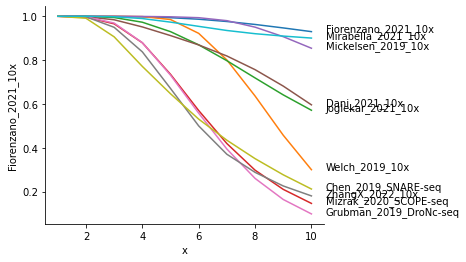

In [ ]:
# Create a line plot with two lines
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col, data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left')
sns.despine()
plt.show()


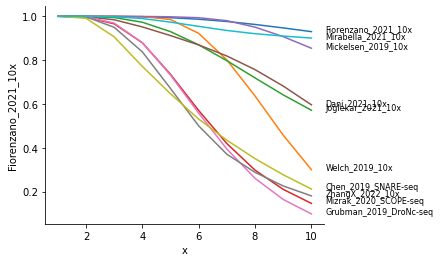

In [ ]:
# Create a line plot with two lines
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col, data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left',fontsize=8)
sns.despine()
plt.show()


In [ ]:
df_smy

cord  clen   cmax
0         6    10   45.0
1         7     9   64.0
2         6    11  134.0
3         6    10  103.0
4         5     7   22.0
...     ...   ...    ...
13209     4     8   16.0
13210     5     6    7.0
13211     3     5   15.0
13212     6    11   46.0
13213     3     8   10.0

[13214 rows x 3 columns]

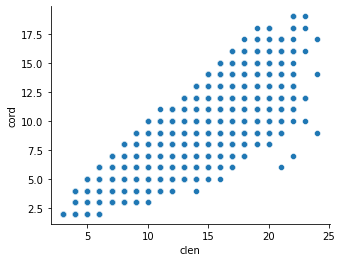

In [ ]:
sns.scatterplot(x='clen',y='cord',data=df_smy)
sns.despine()

<matplotlib.collections.PathCollection>

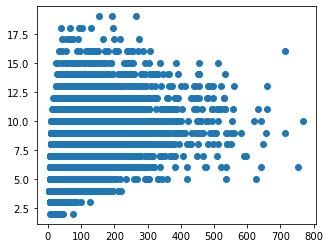

In [ ]:
plt.scatter(df_smy.cmax,df_smy.cord)

<matplotlib.collections.PathCollection>

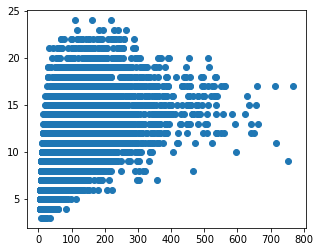

In [ ]:
plt.scatter(df_smy.cmax,df_smy.clen)

## 10 testing dataset with count matrix

In [ ]:
h5_benchmark=['/home/huang_ziliang/project/brain/data/public/human_brain_organoids_Fiorenzano_2021_10x/h5/human_brain_organoids_Fiorenzano_2021_10x.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_mouse_brain_Welch_2019_10x/h5/GSE126836_SN_MD5534.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Visium/h5/mouse_brain_HPF_PFC_Joglekar_2021_10x.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_OB_Mizrak_2020_SCOPE-seq/h5/mouse_brain_OB_Mizrak_2020_SCOPE-seq.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_lateral_hypothalamic_area_Mickelsen_2019_10x/h5/mouse_brain_lateral_hypothalamic_area_Mickelsen_2019_10x.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_choroid_plexus_Dani_2021_10x/h5/mouse_brain_choroid_plexus_Dani_2021_10x.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq/h5/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_developing_ZhangX_2022_10x/h5/Brain-Young-scRNAseq-rep1.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_mouse_brain_Chen_2019_SNARE-seq/h5/RNA.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_Hippocampal_Mirabella_2021_10x/h5/mouse_brain_Hippocampal_Mirabella_2021_10x_in_vivo.h5ad']

In [ ]:
for i in h5_benchmark:
    tmp=sc.read(i)
    print(tmp.shape,i)

(123294, 28788) /home/huang_ziliang/project/brain/data/public/human_brain_organoids_Fiorenzano_2021_10x/h5/human_brain_organoids_Fiorenzano_2021_10x.h5ad
(9192, 29445) /home/huang_ziliang/project/brain/data/public/human_mouse_brain_Welch_2019_10x/h5/GSE126836_SN_MD5534.h5ad
(29375, 32452) /home/huang_ziliang/project/brain/data/public/mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Visium/h5/mouse_brain_HPF_PFC_Joglekar_2021_10x.h5ad
(11020, 48528) /home/huang_ziliang/project/brain/data/public/mouse_brain_OB_Mizrak_2020_SCOPE-seq/h5/mouse_brain_OB_Mizrak_2020_SCOPE-seq.h5ad


/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(7232, 28692) /home/huang_ziliang/project/brain/data/public/mouse_brain_lateral_hypothalamic_area_Mickelsen_2019_10x/h5/mouse_brain_lateral_hypothalamic_area_Mickelsen_2019_10x.h5ad
(98660, 23890) /home/huang_ziliang/project/brain/data/public/mouse_brain_choroid_plexus_Dani_2021_10x/h5/mouse_brain_choroid_plexus_Dani_2021_10x.h5ad
(13214, 10850) /home/huang_ziliang/project/brain/data/public/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq/h5/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq.h5ad
(2751, 31053) /home/huang_ziliang/project/brain/data/public/mouse_brain_developing_ZhangX_2022_10x/h5/Brain-Young-scRNAseq-rep1.h5ad


/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(15390, 33289) /home/huang_ziliang/project/brain/data/public/human_mouse_brain_Chen_2019_SNARE-seq/h5/RNA.h5ad
(16271, 31053) /home/huang_ziliang/project/brain/data/public/mouse_brain_Hippocampal_Mirabella_2021_10x/h5/mouse_brain_Hippocampal_Mirabella_2021_10x_in_vivo.h5ad


## rank 
- try to answer how robust the method is.
- 1. all genes
- 2. hvg

In [ ]:
ad=sc.datasets.pbmc3k()

In [ ]:
#ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq/h5/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq.h5ad')

In [ ]:
smtx = ad.copy().X.tocsr().asfptype()
sc.pp.normalize_total(ad, target_sum=1e4)
smtx1 = ad.copy().X.tocsr().asfptype()
sc.pp.log1p(ad)
smtx2 = ad.copy().X.tocsr().asfptype()

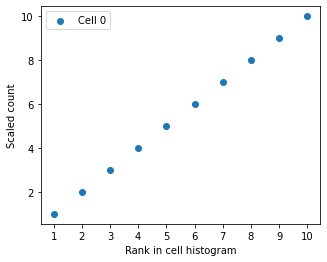

In [ ]:
for c_idx in [0]:
    N = 10
    c = pd.Series(smtx.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(0, N)+1
    plt.scatter(x, y, label=f'Cell {c_idx}');
    

plt.legend()
plt.xlabel('Rank in cell histogram')
plt.ylabel('Scaled count');
plt.xticks(x);

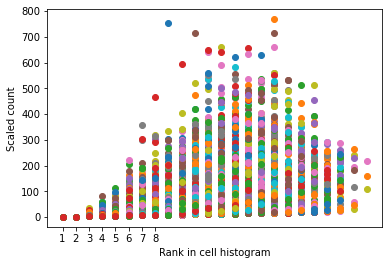

In [ ]:
for c_idx in range(smtx.shape[0:100]):
    c = pd.Series(smtx.getrow(c_idx).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    plt.scatter(x, y);
    

#plt.legend()
plt.xlabel('Rank in cell histogram')
plt.ylabel('Scaled count');
plt.xticks(x);

In [ ]:
smtx.shape[0]

2700

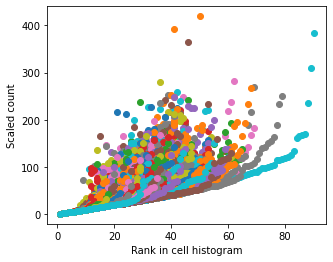

In [ ]:
for c_idx in range(smtx.shape[0]):
    c = pd.Series(smtx.getrow(c_idx).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    plt.scatter(x, y);
    

#plt.legend()
plt.xlabel('Rank in cell histogram')
plt.ylabel('Scaled count');
#plt.xticks(x);

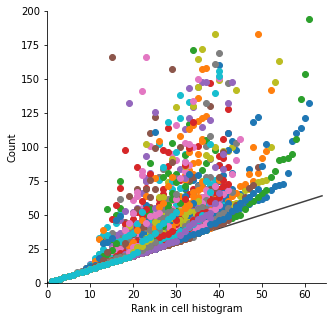

In [ ]:
fig, ax = plt.subplots()
for c_idx in range(200):
    c = pd.Series(smtx.getrow(c_idx).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y);
    

#plt.legend()
#plt.xlim(1,20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(np.arange(65),np.arange(65),'k-', alpha=0.75, zorder=0)
plt.ylim(0,200)
plt.xlim(0,65)
plt.xlabel('Rank in cell histogram')
plt.ylabel('Count');
#plt.xticks(np.arange(0, 20)+1);
#plt.savefig('figures/rank/rankvscount.pdf')

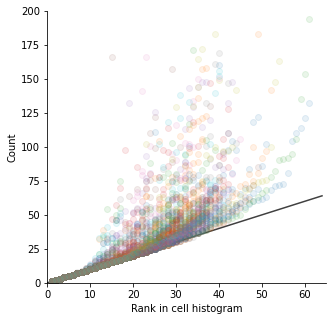

In [ ]:
fig, ax = plt.subplots()
for c_idx in range(200):
    c = pd.Series(smtx.getrow(c_idx).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y,alpha=0.1);
    

#plt.legend()
#plt.xlim(1,20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(np.arange(65),np.arange(65),'k-', alpha=0.75, zorder=0)
plt.ylim(0,200)
plt.xlim(0,65)
plt.xlabel('Rank in cell histogram')
plt.ylabel('Count');
#plt.xticks(np.arange(0, 20)+1);
#plt.savefig('figures/rank/rankvscount.pdf')

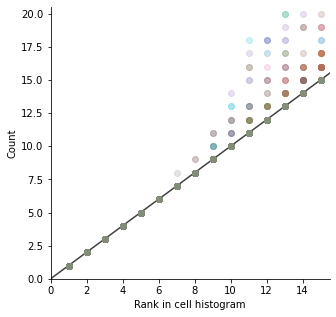

In [ ]:
fig, ax = plt.subplots()
for c_idx in range(200):
    c = pd.Series(smtx.getrow(c_idx).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y, alpha=0.2);
    

#plt.legend()
#plt.xlim(1,20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(np.arange(65),np.arange(65),'k-', alpha=0.75, zorder=0)
plt.ylim(0,20.5)
plt.xlim(0,15.5)
plt.xlabel('Rank in cell histogram')
plt.ylabel('Count');
#plt.xticks(np.arange(0, 20)+1);
#plt.savefig('figures/rank/rankvscount.pdf')

In [ ]:
def plot_mv(cmean,cvar,ax,c='blue'):
    ax.loglog()
    ax.scatter(cmean, cvar,s=50,c=c)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Mean',fontsize=18)
    ax.set_ylabel('Variance',fontsize=18)
    return ax

[]

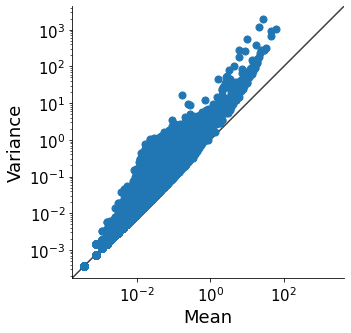

In [ ]:
figsize(5,5)
fig, ax1 = plt.subplots()

cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,ax1,c='#2077B4')
plt.plot()

[]

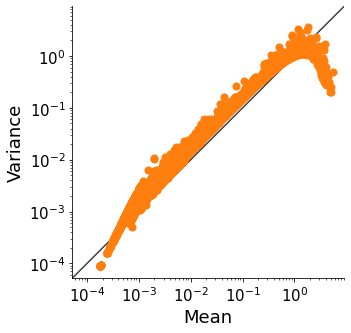

In [ ]:
figsize(5,5)
fig, ax1 = plt.subplots()

cmean = np.array(smtx2.mean(0))
cvar = np.array(smtx2.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,ax1,c='#FF7F0E')
plt.plot()

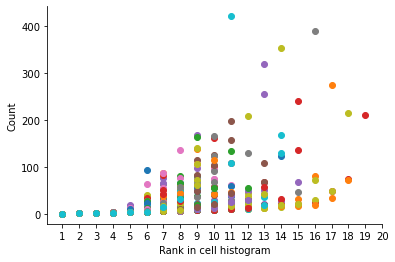

In [ ]:
fig, ax = plt.subplots()
for c_idx in range(200):
    c = pd.Series(smtx.getrow(c_idx).data)
    c=c.value_counts().sort_index()
    y = np.array(c.index)
    x = np.arange(0, c.shape[0])+1
    ax.scatter(x, y);
    

#plt.legend()
#plt.xlim(1,20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Rank in cell histogram')
plt.ylabel('Count');
plt.xticks(np.arange(0, 20)+1);
plt.savefig('figures/rank/rankvscount.pdf')

In [ ]:
df=[]
cmax=[]
for c_idx in range(smtx.shape[0]):
    N = 10
    c = pd.Series(smtx.getrow(c_idx).data)
    c=c.value_counts().sort_index()
    cmax.append(c.index[-1])
    try:
        df.append((c.index==(np.arange(0, c.shape[0])+1)))
    except:
        print(c_idx,len(c))

In [ ]:
df_smy=pd.DataFrame([[x.sum(),x.shape[0]] for x in df])

In [ ]:
df_smy.columns=['cord','clen']
df_smy['cmax']=cmax

In [ ]:
df_smy

cord  clen   cmax
0         6    10   45.0
1         7     9   64.0
2         6    11  134.0
3         6    10  103.0
4         5     7   22.0
...     ...   ...    ...
13209     4     8   16.0
13210     5     6    7.0
13211     3     5   15.0
13212     6    11   46.0
13213     3     8   10.0

[13214 rows x 3 columns]

In [ ]:
import seaborn as sns

In [ ]:
cord_rate=[sum(df_smy.cord>(i+1))/df_smy.shape[0] for i in range(10)]

In [ ]:
cord_rate

[1.0,
 0.9976540033298017,
 0.9688966247918874,
 0.8792946874527017,
 0.7309671560466172,
 0.5575904343877706,
 0.3939004086574845,
 0.2599515665203572,
 0.16361434841834419,
 0.09777508702890873]

In [ ]:
def get_ranks(file):
    ad=sc.read(file)
    smtx = ad.X.tocsr().asfptype()
    df=[]
    cmax=[]
    for c_idx in range(smtx.shape[0]):
        c = pd.Series(smtx.getrow(c_idx).data)
        c=c.value_counts().sort_index()
        cmax.append(c.index[-1])
        try:
            df.append((c.index==(np.arange(0, c.shape[0])+1)))
        except:
            print(c_idx,len(c))

    df_smy=pd.DataFrame([[x.sum(),x.shape[0]] for x in df])
    df_smy.columns=['cord','clen']
    df_smy['cmax']=cmax
    return df_smy

In [ ]:
df_lst = [get_ranks(f) for f in h5_benchmark]

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
df_rate=pd.DataFrame([[sum(df_smy.cord>(i+1))/df_smy.shape[0] for i in range(10)] for df_smy in df_lst])

In [ ]:
df_rate.index=[s.split('/')[7] for s in h5_benchmark]

In [ ]:
s=h5_benchmark[0].split('/')[7].split('_')

In [ ]:
'_'.join(s[-3:])

'Fiorenzano_2021_10x'

In [ ]:
df_rate

0         1  \
human_brain_organoids_Fiorenzano_2021_10x           1.000000  0.999870   
human_mouse_brain_Welch_2019_10x                    1.000000  1.000000   
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  1.000000  0.999591   
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.999546  0.995917   
mouse_brain_lateral_hypothalamic_area_Mickelsen...  1.000000  1.000000   
mouse_brain_choroid_plexus_Dani_2021_10x            0.999787  0.997871   
human_brain_entorhinalcortex_Grubman_2019_DroNc...  1.000000  0.997654   
mouse_brain_developing_ZhangX_2022_10x              1.000000  0.997455   
human_mouse_brain_Chen_2019_SNARE-seq               1.000000  0.990838   
mouse_brain_Hippocampal_Mirabella_2021_10x          1.000000  1.000000   

                                                           2         3  \
human_brain_organoids_Fiorenzano_2021_10x           0.998921  0.997210   
human_mouse_brain_Welch_2019_10x                    1.000000  0.998477   
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  0.994111  0.972698   
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.965426  0.878947   
mouse_brain_lateral_hypothalamic_area_Mickelsen...  0.999862  0.999032   
mouse_brain_choroid_plexus_Dani_2021_10x            0.983874  0.951267   
human_brain_entorhinalcortex_Grubman_2019_DroNc...  0.968897  0.879295   
mouse_brain_developing_ZhangX_2022_10x              0.949473  0.837514   
human_mouse_brain_Chen_2019_SNARE-seq               0.906043  0.771020   
mouse_brain_Hippocampal_Mirabella_2021_10x          0.997787  0.989491   

                                                           4         5  \
human_brain_organoids_Fiorenzano_2021_10x           0.993333  0.986406   
human_mouse_brain_Welch_2019_10x                    0.984987  0.921889   
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  0.929702  0.869515   
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.734936  0.569601   
mouse_brain_lateral_hypothalamic_area_Mickelsen...  0.997511  0.993363   
mouse_brain_choroid_plexus_Dani_2021_10x            0.911758  0.869065   
human_brain_entorhinalcortex_Grubman_2019_DroNc...  0.730967  0.557590   
mouse_brain_developing_ZhangX_2022_10x              0.670302  0.499455   
human_mouse_brain_Chen_2019_SNARE-seq               0.646199  0.530409   
mouse_brain_Hippocampal_Mirabella_2021_10x          0.973142  0.953844   

                                                           6         7  \
human_brain_organoids_Fiorenzano_2021_10x           0.976017  0.962520   
human_mouse_brain_Welch_2019_10x                    0.800479  0.635988   
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  0.797072  0.718502   
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.418875  0.297459   
mouse_brain_lateral_hypothalamic_area_Mickelsen...  0.979812  0.950221   
mouse_brain_choroid_plexus_Dani_2021_10x            0.818620  0.756213   
human_brain_entorhinalcortex_Grubman_2019_DroNc...  0.393900  0.259952   
mouse_brain_developing_ZhangX_2022_10x              0.370047  0.287532   
human_mouse_brain_Chen_2019_SNARE-seq               0.434113  0.350097   
mouse_brain_Hippocampal_Mirabella_2021_10x          0.934976  0.920349   

                                                           8         9  
human_brain_organoids_Fiorenzano_2021_10x           0.946697  0.929753  
human_mouse_brain_Welch_2019_10x                    0.456919  0.299608  
mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Vi...  0.641055  0.570928  
mouse_brain_OB_Mizrak_2020_SCOPE-seq                0.209800  0.145735  
mouse_brain_lateral_hypothalamic_area_Mickelsen...  0.906803  0.853982  
mouse_brain_choroid_plexus_Dani_2021_10x            0.681198  0.595642  
human_brain_entorhinalcortex_Grubman_2019_DroNc...  0.163614  0.097775  
mouse_brain_developing_ZhangX_2022_10x              0.225373  0.179935  
human_mouse_brain_Chen_2019_SNARE-seq               0.276283  0.211371  
mouse_brain_Hippocampal_Mirabella_2021_10x          0.909471  0.90037

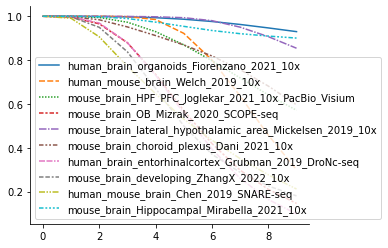

In [ ]:
figsize(5,4)
sns.lineplot(data=df_rate.T)
sns.despine()
#plt.legend().remove()
#plt.xticks(ticks=list(range(0,len(tmp1),2)))
plt.show()

In [ ]:
['_'.join(s.split('/')[7].split('_')[-3:]) for s in h5_benchmark]

['Fiorenzano_2021_10x',
 'Welch_2019_10x',
 '10x_PacBio_Visium',
 'Mizrak_2020_SCOPE-seq',
 'Mickelsen_2019_10x',
 'Dani_2021_10x',
 'Grubman_2019_DroNc-seq',
 'ZhangX_2022_10x',
 'Chen_2019_SNARE-seq',
 'Mirabella_2021_10x']

In [ ]:
df=df_rate.T

In [ ]:
df.columns=['Fiorenzano_2021_10x',
 'Welch_2019_10x',
 'Joglekar_2021_10x',
 'Mizrak_2020_SCOPE-seq',
 'Mickelsen_2019_10x',
 'Dani_2021_10x',
 'Grubman_2019_DroNc-seq',
 'ZhangX_2022_10x',
 'Chen_2019_SNARE-seq',
 'Mirabella_2021_10x']

In [ ]:
df['x']=[i+1 for i in range(10)]

In [ ]:
df

Fiorenzano_2021_10x  Welch_2019_10x  Joglekar_2021_10x  \
0             1.000000        1.000000           1.000000   
1             0.999870        1.000000           0.999591   
2             0.998921        1.000000           0.994111   
3             0.997210        0.998477           0.972698   
4             0.993333        0.984987           0.929702   
5             0.986406        0.921889           0.869515   
6             0.976017        0.800479           0.797072   
7             0.962520        0.635988           0.718502   
8             0.946697        0.456919           0.641055   
9             0.929753        0.299608           0.570928   

   Mizrak_2020_SCOPE-seq  Mickelsen_2019_10x  Dani_2021_10x  \
0               0.999546            1.000000       0.999787   
1               0.995917            1.000000       0.997871   
2               0.965426            0.999862       0.983874   
3               0.878947            0.999032       0.951267   
4               0.734936            0.997511       0.911758   
5               0.569601            0.993363       0.869065   
6               0.418875            0.979812       0.818620   
7               0.297459            0.950221       0.756213   
8               0.209800            0.906803       0.681198   
9               0.145735            0.853982       0.595642   

   Grubman_2019_DroNc-seq  ZhangX_2022_10x  Chen_2019_SNARE-seq  \
0                1.000000         1.000000             1.000000   
1                0.997654         0.997455             0.990838   
2                0.968897         0.949473             0.906043   
3                0.879295         0.837514             0.771020   
4                0.730967         0.670302             0.646199   
5                0.557590         0.499455             0.530409   
6                0.393900         0.370047             0.434113   
7                0.259952         0.287532             0.350097   
8                0.163614         0.225373             0.276283   
9                0.097775         0.179935             0.211371   

   Mirabella_2021_10x   x  
0            1.000000   1  
1            1.000000   2  
2            0.997787   3  
3            0.989491   4  
4            0.973142   5  
5            0.953844   6  
6            0.934976   7  
7            0.920349   8  
8            0.909471   9  
9            0.900375  10

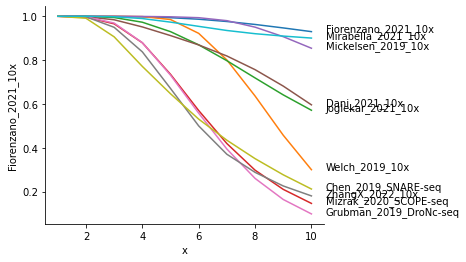

In [ ]:
# Create a line plot with two lines
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col, data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left')
sns.despine()
plt.show()


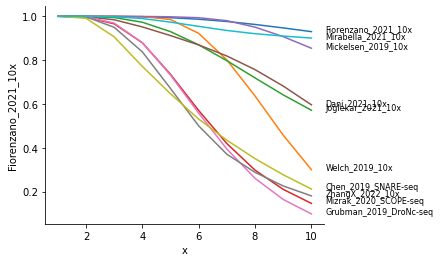

In [ ]:
# Create a line plot with two lines
for col in df.columns[:-1]:
    sns.lineplot(x='x', y=col, data=df)

    # Get the last x and y values of the line
    x_last = df['x'].iloc[-1]
    y_last = df[col].iloc[-1]

    # Add an annotation with the name of the line at the last point
    plt.gca().annotate(col, xy=(x_last, y_last), xytext=(x_last + 0.5, y_last), ha='left',fontsize=8)
sns.despine()
plt.show()


In [ ]:
df_smy

cord  clen   cmax
0         6    10   45.0
1         7     9   64.0
2         6    11  134.0
3         6    10  103.0
4         5     7   22.0
...     ...   ...    ...
13209     4     8   16.0
13210     5     6    7.0
13211     3     5   15.0
13212     6    11   46.0
13213     3     8   10.0

[13214 rows x 3 columns]

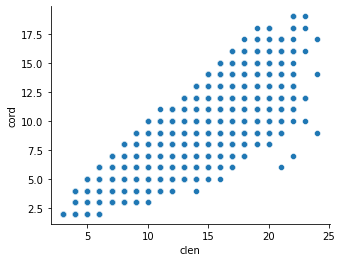

In [ ]:
sns.scatterplot(x='clen',y='cord',data=df_smy)
sns.despine()

<matplotlib.collections.PathCollection>

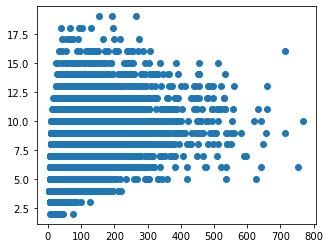

In [ ]:
plt.scatter(df_smy.cmax,df_smy.cord)

<matplotlib.collections.PathCollection>

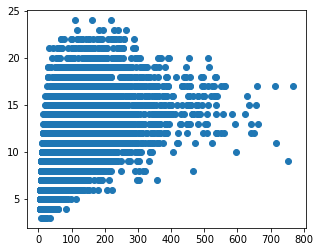

In [ ]:
plt.scatter(df_smy.cmax,df_smy.clen)

## sum of de-normalisation

In [ ]:
smtx1.getrow(c_idx).data.sum()

10000.0

In [ ]:
tmp=pd.Series([(smtx1.getrow(i).data+1).sum() for i in range(smtx1.shape[0])])

<AxesSubplot:>

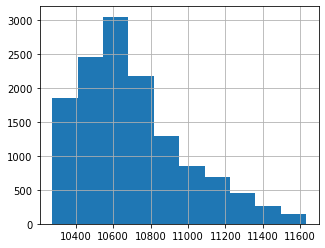

In [ ]:
tmp.hist()

In [ ]:
tmp=pd.Series([10000/(smtx.getrow(i).data.sum()) for i in range(smtx.shape[0])])

<AxesSubplot:>

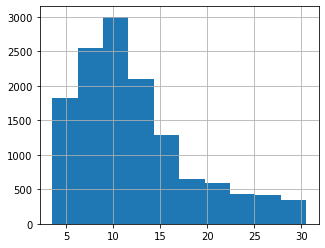

In [ ]:
tmp.hist()

In [ ]:
ad=sc.read(h5_benchmark[0])

In [ ]:
smtx = ad.copy().X.tocsr().asfptype()
sc.pp.normalize_total(ad, target_sum=1e4)
smtx1 = ad.copy().X.tocsr().asfptype()
sc.pp.log1p(ad)
smtx2 = ad.copy().X.tocsr().asfptype()

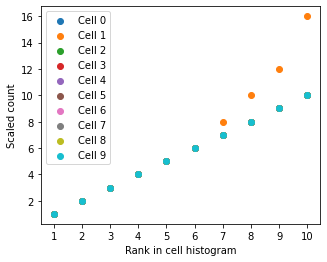

In [ ]:
for c_idx in range(10):
    N = 10
    c = pd.Series(smtx.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(0, N)+1
    plt.scatter(x, y, label=f'Cell {c_idx}');
    

plt.legend()
plt.xlabel('Rank in cell histogram')
plt.ylabel('Scaled count');
plt.xticks(x);

In [ ]:
s=1
c=1
base=2

In [ ]:
sum((np.log(s*x+c)/np.log(base)-y)**2)

7.286718371442067

In [ ]:
def func(x):
    return [x[0] * np.cos(x[1]) - 4,
            x[1] * x[0] - x[1] - 5]
root = fsolve(func, [1, 1])
root

array([6.50409711, 0.90841421])

In [ ]:
np.isclose(func(root), [0.0, 0.0])

array([ True,  True])

In [ ]:
def f1(p):
    return sum(np.abs(np.log(p[0]*x+np.exp(p[2]))/np.log(p[1])-y))
res = minimize(f1, [1,2.7,0.1], method='Nelder-Mead', tol=1e-6)

In [ ]:
def f1(p):
    return sum(np.abs(np.log(p[0]*x+np.exp(p[2]))/np.log(p[1])-y))
res = minimize(f1, [1,2.7,0.1], method='Nelder-Mead', tol=1e-6)

In [ ]:
def f1(p):
    return sum(np.abs(p[0]*x+p[2]-np.exp(np.log(p[1])*y)))
res = minimize(f1, [1,2.7,0.1], method='Nelder-Mead', tol=1e-6)

In [ ]:
ress=[]
for c_idx in range(10):
    try:
        N = 8
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(N).index)
        x = np.arange(1, N+1)
        res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
        ress.append(res.x[1])
        print(res.x,f1(res.x))
    except:
        print(c_idx)

[0.90260797 2.71828112 1.00000029] 1.5853433561474617e-06
[6.00189965e-08 1.00000022e+00 1.00000062e+00] 1.8463570228277604e-07
[1.15486795 2.71828195 0.99999986] 2.5790225048893944e-06
[0.32898219 1.69730915 1.69502804] 0.5967898767622923
[0.91346213 2.67403659 1.01408332] 0.07457563138803547
[0.6915631  2.71828201 0.99999983] 7.082936315239152e-07
[1.12296462 2.71828175 0.99999984] 2.045589164723083e-06
[0.5539304  3.85147342 0.81155853] 0.4184862714554203
[0.96024537 2.71828115 1.00000019] 1.3261944968867567e-06
[0.50072608 2.71828186 1.00000003] 4.095178145480105e-07


In [ ]:
def f1(p):
    return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
res = minimize(f1, [1,2.7,0.1], method='Nelder-Mead', tol=1e-6)

In [ ]:
def f1(p):
    return sum((np.log(p[0]*x+p[2])/np.log(p[1])-y)**2)
res = minimize(f1, [1,2.7,0.1], method='Nelder-Mead', tol=1e-6)

In [ ]:
def f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    return np.sum((u-y)**2)

def grad_f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    dudx = p[0]/((p[0]*x+p[2])*np.log(p[1]))
    dudp = 1/np.log(p[1])
    grad_u = np.vstack((dudx, np.zeros_like(p[1:]), dudp))
    return 2*np.sum(grad_u*(u-y), axis=1)
bounds = [(1e-6, None), (1.9, None), (1e-6, None)]
res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-6, bounds=bounds, args=(x, y))

In [ ]:
def f1(p, x, y):
    a = np.exp(p[0])
    b = p[1]
    c = np.exp(p[2])
    u = np.log(a*x+c)/np.log(b)
    return np.sum((u-y)**2)

def grad_f1(p, x, y):
    a = np.exp(p[0])
    b = p[1]
    c = np.exp(p[2])
    dx = a*x + c
    u = np.log(dx) / np.log(b)
    dudx = a/(dx*np.log(b))
    dudb = -np.log(dx)*(u-y)/(np.log(b)**2)
    dudc = 1/(dx*np.log(b))
    grad_u = np.array([dudx, dudb, dudc])
    return 2*np.sum(grad_u*(u-y), axis=1)

bounds = [(None, None), (1.9, None), (None, None)]
res = minimize(f1, [0, 2.7, 0], method='L-BFGS-B', tol=1e-6, bounds=bounds, jac=grad_f1, args=(x, y))

In [ ]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.003952933025822436
        x: [ 5.211e+00  2.403e+00  2.591e+00]
      nit: 14
      jac: [-1.477e-03 -5.288e-03  2.190e-03]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [ ]:
ress=[]
for c_idx in range(10):
    N = 8
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[2.56370408 1.9        2.94344644] 0.06361982148129575 0.06361982148129575 True
[8.32720351 2.43104078 2.77010445] 0.007479606634767787 0.007479606634767787 True
[2.0152444  1.9        2.07147607] 0.2120217861708384 0.2120217861708384 True
[2.14996735 1.9        2.8247274 ] 0.03441619808948135 0.03441619808948135 True


ValueError: operands could not be broadcast together with shapes (8,) (7,) 

In [ ]:
ress=[]
for c_idx in range(10):
    N = 5
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[13.15789521  2.718281    0.99997125] 2.258839281990698e-12 2.258839281990698e-12 True
[13.88878355  2.71827732  1.00004075] 2.9801294465320357e-13 2.9801294465320357e-13 True
[8.27121976 2.7182757  1.0000396 ] 8.699463057408732e-13 8.699463057408732e-13 True
[10.81073449  2.71827649  0.99999898] 4.780123767790999e-12 4.780123767790999e-12 True
[17.79349189  2.71827826  1.00001533] 1.0154650606892559e-12 1.0154650606892559e-12 True
[4.55457267 1.9        3.90293953] 0.03799356142630135 0.03799356142630135 True
[17.06446169  2.71826906  1.00015232] 2.0636361340273303e-12 2.0636361340273303e-12 True
[21.14151675  2.71827792  1.0000155 ] 1.7953689485461354e-12 1.7953689485461354e-12 True
[15.12841927  2.71827547  1.00006125] 2.8118484471295196e-12 2.8118484471295196e-12 True
[23.0945001   2.71827726  1.00006147] 3.7606575529895596e-13 3.7606575529895596e-13 True


In [ ]:
ress=[]
for c_idx in range(10):
    N = 4
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[13.15773008  2.71827618  1.00008993] 1.515916207756846e-11 1.515916207756846e-11 True
[13.88829764  2.71826135  1.00047046] 1.6637658895399393e-10 1.6637658895399393e-10 True
[8.27121765 2.718275   1.0000305 ] 1.9212719713983048e-13 1.9212719713983048e-13 True
[10.81018275  2.71824626  1.00030548] 2.775242590617985e-11 2.775242590617985e-11 True
[17.79275332  2.71825397  1.00026364] 4.606949470607632e-12 4.606949470607632e-12 True
[27.24766655  2.71827614  1.00008335] 3.8229464016792645e-13 3.8229464016792645e-13 True
[17.06456818  2.71827208  1.00009363] 3.713459232533978e-13 3.713459232533978e-13 True
[21.14134415  2.71827388  1.00011844] 6.305768647007579e-13 6.305768647007579e-13 True
[15.12838449  2.71827332  1.00006748] 3.895258830781943e-13 3.895258830781943e-13 True
[23.09422721  2.71827065  1.00014801] 5.72809514167958e-13 5.72809514167958e-13 True


In [ ]:
ress=[]
for c_idx in range(10):
    N = 3
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[13.15710769  2.71824404  1.00028616] 3.4602550999426713e-12 3.4602550999426713e-12 True
[13.88892979  2.71828281  0.99998515] 3.485082404491323e-12 3.485082404491323e-12 True
[8.27114143 2.7182681  1.00005365] 3.028513821893029e-13 3.028513821893029e-13 True
[10.81051462  2.71826376  1.00010867] 7.776457946024647e-13 7.776457946024647e-13 True
[17.79299149  2.71826117  1.00018013] 6.102724772294388e-13 6.102724772294388e-13 True
[27.24685134  2.71825937  1.00032466] 5.151429710146507e-13 5.151429710146507e-13 True
[17.06419467  2.71825833  1.00020352] 6.291493334481177e-13 6.291493334481177e-13 True
[21.14053416  2.71825107  1.00035087] 1.2263477288768057e-12 1.2263477288768057e-12 True
[15.1281495   2.71826324  1.00013788] 4.1059679516802865e-13 4.1059679516802865e-13 True
[23.09399068  2.71826459  1.00021375] 7.13905344909986e-13 7.13905344909986e-13 True


In [ ]:
ress=[]
for c_idx in range(10):
    N = 8
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-6, bounds=bounds, args=(x, y))
    #res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y))

[-1.02563539e-01  2.71816065e+00  5.26853982e-05] 6.105508837254829e-10
[1.27906084 2.04638336 1.19204459] 0.01754756999619913
[ 1.44193579e-01  2.71849110e+00 -1.27511814e-04] 9.611570550941814e-10
[ 0.69178164  2.80623978 -0.11046898] 0.0001462762249969899
[-5.22965962e-02  2.71860836e+00 -1.57989999e-04] 1.1950419615387554e-09
[-3.67593725e-01  2.71974667e+00 -4.62220243e-04] 1.6574850873836957e-08
[ 1.16982378e-01  2.71931120e+00 -6.90132593e-04] 1.7165491225260408e-08
[-1.16202586e+00  2.72773574e+00 -1.09693239e-03] 2.0343437408518346e-07
[-4.02726366e-02  2.71861222e+00 -1.37638932e-04] 1.2922594435144346e-09
[-6.91454924e-01  2.71893224e+00  2.92314120e-04] 8.118887922455662e-08


In [ ]:
ress=[]
for c_idx in range(10):
    N = 8
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [1, 2.7, 0.1], method='TNC', tol=1e-6, bounds=bounds, args=(x, y))
    #res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y))

[0.90111414 2.71637695 1.0008053 ] 4.0075970385755286e-08
[4.05386318 2.09691912 3.35861517] 0.018117392308175866
[1.24359358 2.79766385 0.95054019] 8.154567317349875e-05
[1.93192417 2.77492506 0.93632634] 5.9872463543027705e-05
[0.9505692  2.72028717 0.99860235] 9.401733997264072e-08
[0.70258976 2.73619405 0.99123387] 5.5197853530991196e-06
[1.21262178 2.80135536 0.94976341] 8.696757294510604e-05
[0.65102871 4.3541594  0.78505878] 0.0034458657511302125
[0.96374017 2.72232105 0.9981563 ] 1.8434844340727636e-07
[0.49540275 2.704044   1.00284803] 9.97783227679906e-07


In [ ]:
x

array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
y

array([0.40594903, 0.69387299, 0.91716164, 1.09957993, 1.25379968,
       1.38738286, 1.50520623, 1.61059892])

In [ ]:
res.success

True

In [ ]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8.118887922455662e-08
        x: [-6.915e-01  2.719e+00  2.923e-04]
      nit: 27
      jac: [-2.980e-04  2.689e-04  2.030e-04]
     nfev: 116
     njev: 29
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [ ]:
np.log(1)

0.0

In [ ]:
np.exp(-1.04305184)

0.3523776391393103

In [ ]:
np.exp(0.66247546)

1.9395877684378906

In [ ]:
np.tan(0)

0.0

In [ ]:
np.tan(3)

-0.1425465430742778

In [ ]:
ress=[]
for c_idx in range(10):
    try:
        N = 5
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(N).index)
        x = np.arange(1, N+1)
        res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
        ress.append(res.x[1])
        print(res.x,f1(res.x))
    except:
        print(c_idx)

[0.95120714 1.58335931 2.42897423] 0.28603599949981495
[1.09311116 1.62298553 2.68531024] 0.2777071514565348
[0.66151303 1.54164542 1.96045345] 0.29088432722805146
[2.83135343 2.04310959 3.5866975 ] 0.18528786083299087
[20.35226679  2.79641853  0.07050236] 0.01332655258410842
[0.41235361 1.3089098  2.04573675] 0.26190100882527867
[27.88914272  3.01977773 -3.39669655] 0.04849843162440681
[1.25443739 1.59694527 3.00826275] 0.28796216494269355
[2.27176875 1.83677514 3.15114165] 0.2017869748212222
[0.5402857  1.39220558 2.32562823] 0.376492970507428


/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))


In [ ]:
res.values

<function OptimizeResult.values>

In [ ]:
ress=[]
for c_idx in range(10):
    try:
        N = 3
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(N).index)
        x = np.arange(1, N+1)
        res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
        ress.append(res.x[1])
        print(res.x)
    except:
        print(c_idx)

[0.2679528  1.26942527 1.61390619]
[5.16536267 2.17534629 2.99170972]
[1.18444133 1.70430126 2.10558885]
[0.28035817 1.28731827 1.58523225]
[0.35817699 1.30565491 1.82849923]
[0.44773181 1.32327373 2.10164609]
[1.49158651 1.64961904 2.76539089]
[0.32580313 1.28090305 1.8271143 ]
[1.69626539 1.71036815 2.75204643]
[0.25727342 1.24031351 1.72706774]


/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return sum(np.abs(np.log(p[0]*x+p[2])/np.log(p[1])-y))
/tmp/ipykernel_28611/2528691554.py:2: RuntimeWarning: divide by zero encountered i

In [ ]:
ress=[]
for c_idx in range(10):
    try:
        N = 3
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(N).index)
        x = np.arange(1, N+1)
        res = minimize(f1, [1,2.7,0.9], method='Nelder-Mead', tol=1e-6)
        ress.append(res.x[1])
        print(res.x)
    except:
        print(c_idx)

[2.80535083 0.65472838 2.86271499]
[1.92583522 0.57095588 2.7477764 ]
[3.40065023 0.77503525 2.21949309]
[2.65549503 0.6716929  2.5955131 ]
[7.85738076 0.8241819  3.36321287]
[26.60398389  0.99519244  1.19387244]
[10.56869572  0.89503789  2.75584005]
[23.47780622  1.02222995  0.24215433]
[0.52733665 0.33158218 1.98696559]
[23.04374152  0.99954104  1.01578268]


In [ ]:
np.mean(ress)

3.7885541950935435

In [ ]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.819945249006196e-09
             x: [ 2.309e+01  2.718e+00]
           nit: 152
          nfev: 275
 final_simplex: (array([[ 2.309e+01,  2.718e+00],
                       [ 2.309e+01,  2.718e+00],
                       [ 2.309e+01,  2.718e+00]]), array([ 3.820e-09,  4.121e-09,  5.656e-09]))

In [ ]:
res.x

array([23.18539954,  2.72049798,  0.97184919])

In [ ]:
np.e

2.718281828459045

In [ ]:
res = minimize(f1, [1,1,2.7], method='Nelder-Mead', tol=1e-6)

In [ ]:
f1(res.x)

0.031098473729801346

## 3.Real data with raw and normalized

In [ ]:
import scanpy as sc

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_source_Velmeshev_2019/h5/brain_source_Velmeshev_2019.h5')

In [ ]:
ad

AnnData object with n_obs × n_vars = 104559 × 65217
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids'

In [ ]:
ad.X.data

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
import gzip
import csv

genes,rows=[],[]
with gzip.open('/home/huang_ziliang/project/brain/data/public/human_brain_source_Velmeshev_2019/exprMatrix.tsv.gz', 'rt') as file:
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        genes.append(row[0])
        try:
            rows.append([float(i) for i in row[1:1001]])
        except:
            cells=row[1:1001]
            print(row[0])

gene_ID


In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

In [ ]:
smtx=np.array(rows)
smtx=smtx.T 
smtx = csr_matrix(smtx)
smtx.eliminate_zeros() 
smtx.shape

In [ ]:
ad.var['gene_name']=list(ad.var.index)
ad.var.index=list(ad.var.gene_ids)

In [ ]:
ad=ad[cells,[i.split('|')[0] for i in genes[1:]]]

In [ ]:
ad.layers['expr']=smtx

In [ ]:
ad.layers['counts']=ad.X.copy()

In [ ]:
ad.write_h5ad('data/realdata/human_brain_source_Velmeshev_2019_first1000.h5ad')

## norm

In [ ]:
ad=sc.read('data/realdata/human_brain_source_Velmeshev_2019_first1000.h5ad')

In [ ]:
ad

AnnData object with n_obs × n_vars = 1000 × 36501
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids', 'gene_name'
    layers: 'counts', 'expr'

In [ ]:
ad.X=ad.layers['counts'].copy()

In [ ]:
smtx = ad.copy().X.tocsr().asfptype()
sc.pp.normalize_total(ad, target_sum=1e4)
smtx1 = ad.copy().X.tocsr().asfptype()
smtx2 = ad.copy().X#.tocsr().asfptype()
smtx2.data = np.log2(smtx2.data+1)

In [ ]:
smtx2

<1000x36501 sparse matrix of type '<class 'numpy.float32'>'
	with 2173216 stored elements in Compressed Sparse Row format>

In [ ]:
smtx2.data

array([3.7990766, 3.7990766, 3.7990766, ..., 3.6265254, 2.7388475,
       3.6265254], dtype=float32)

In [ ]:
smtx3=smtx2.astype(np.float64)

In [ ]:
smtx3.data

array([3.79907656, 3.79907656, 3.79907656, ..., 3.6265254 , 2.73884749,
       3.6265254 ])

In [ ]:
ad.layers['expr'].data

array([3.79907659, 3.79907659, 3.79907659, ..., 3.62652532, 2.73884757,
       3.62652532])

In [ ]:
max(abs(smtx2.data-ad.layers['expr'].data))

0.0023246554207609904

In [ ]:
max(abs(smtx3.data-ad.layers['expr'].data))

0.0023246554207609904

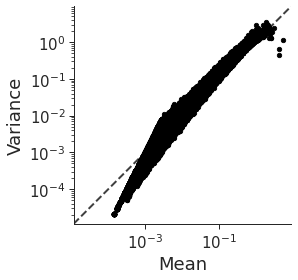

In [ ]:
cmean = np.array(smtx2.mean(0))
cvar = np.array(smtx2.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='black',fit=False)

- total expression distribution

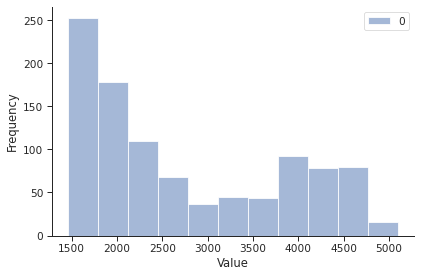

In [ ]:
histplot(smtx2.sum(axis=1),color='#2077B4')#,save='figures/pbmc_sum_scaled_count+pseudo.pdf')

In [ ]:
smtx1.data=smtx1.data+1

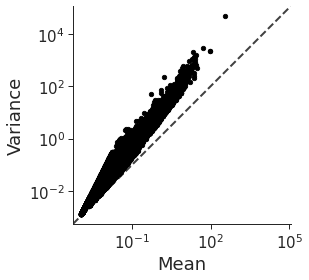

In [ ]:
cmean = np.array(smtx1.mean(0))
cvar = np.array(smtx1.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='black',fit=False)

- total expression distribution

In [ ]:
sns.histplot

<function seaborn.distributions.histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)>

In [ ]:
def histplot(data,color,xl='Value',yl='Frequency',save=None):
    fig, ax = plt.subplots()
    # Create the histogram using Seaborn
    ax.hist(data, color=color)
   
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(xl,fontsize=18)
    ax.set_ylabel(yl,fontsize=18)
    # Save the plot in a Nature journal style
    if save:
        plt.savefig(save,dpi=300,bbox_inches='tight',transparent=True)
    plt.show()

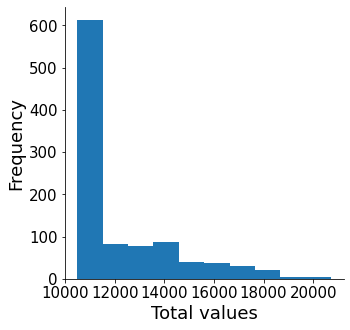

In [ ]:
histplot(smtx1.sum(axis=1),color='#2077B4',xl='Total values',save='figures/pbmc_sum_scaled_count+pseudo.pdf')

In [ ]:
smtx1.data=smtx1.data-1

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

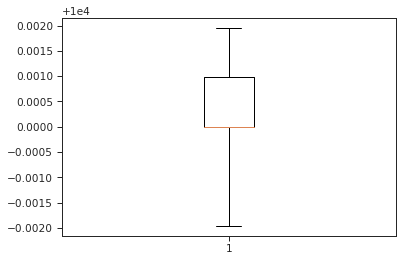

In [ ]:
plt.boxplot(smtx1.sum(axis=1))

In [ ]:
smtx1.astype(np.float16)

<1000x36501 sparse matrix of type '<class 'numpy.float16'>'
	with 2173216 stored elements in Compressed Sparse Row format>

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

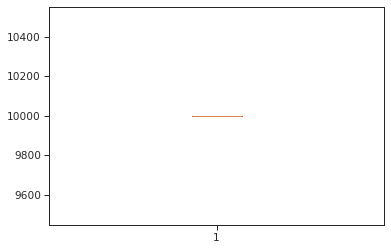

In [ ]:
plt.boxplot(smtx1.astype(np.float16).sum(axis=1))

[<matplotlib.lines.Line2D>]

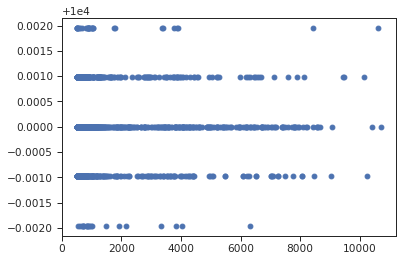

In [ ]:
plt.plot((smtx1>0).sum(axis=1),smtx1.sum(axis=1),'o')

### denorm

In [ ]:
ad.X=ad.layers['expr'].copy()

In [ ]:
smtx2=ad.X.copy()

##### auto 1

In [ ]:
np.random.seed(0)
num=100
ress=[]
for _ in range(num):
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    ress.append([res.x[0],res.x[1],res.fun])

In [ ]:
ress=pd.DataFrame(ress,columns=['base','pseudo','loss'])

In [ ]:
ress.base.mean()

1.9999999887857882

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

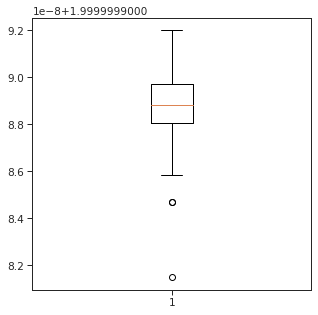

In [ ]:
plt.boxplot(ress.base)

/home/huang_yin/anaconda3/envs/sc06/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='base'>

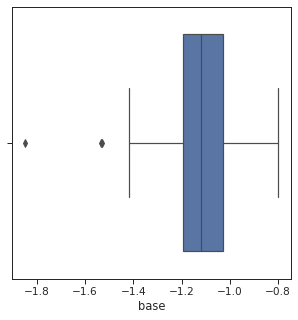

In [ ]:
sns.boxplot((ress.base-2)*10**8)

/home/huang_yin/anaconda3/envs/sc06/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pseudo'>

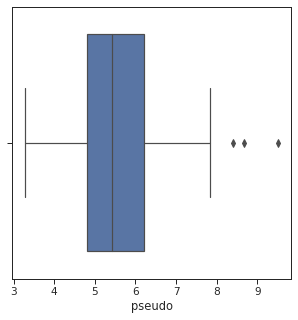

In [ ]:
sns.boxplot((ress.pseudo-1)*10**8)

/home/huang_yin/anaconda3/envs/sc06/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loss'>

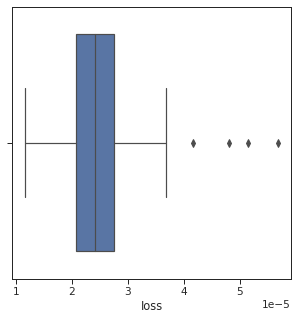

In [ ]:
sns.boxplot((ress.loss)*10**8)

### Fitted curve

In [ ]:
np.random.seed(0)
ys=[]
for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(2).index)
        ys.append(y)
    except:
        print(c_idx)
ys=np.array(ys)
y1=ys[:,0]
y2=ys[:,1]
res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))

In [ ]:
"#4C72B0" (blue)
"#DD8452" (orange)
"#55A868" (green)
"#C44E52" (red)
"#8172B2" (purple)
"#937860" (brown)
"#DA8BC3" (pink)
"#8C8C8C" (gray)
"#CCB974" (yellow)
"#64B5CD" (turquoise)

In [ ]:
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.1748333239079074e-13
        x: [ 2.000e+00  1.000e+00]
      nit: 50
      jac: [ 2.605e-11 -7.546e-12]
     nfev: 153
     njev: 51
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [ ]:
def predbybc(y1,base,cont):
    return np.log(2*np.exp(y1*np.log(base))-cont)/np.log(base)

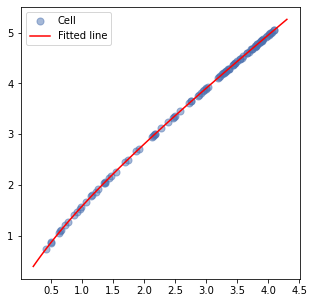

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# generate some sample data
x = y1
y = y2

# fit a line to the data
x_new=np.linspace(min(x)-0.2,max(x)+0.2,num=100)
fitted_y = predbybc(x_new,res.x[0],res.x[1])

# plot the data and the fitted line
plt.scatter(x, y, s=50, c='#4C72B0', alpha=0.5,label='Cell')
plt.plot(x_new, fitted_y, c='#DD8452', label='Fitted line')
plt.legend()
plt.show()

In [ ]:
def plot_fitted(x,y,save=None):
    x_new=np.linspace(min(x),max(x),num=100)
    fitted_y = predbybc(x_new,res.x[0],res.x[1])

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=50, c='#4C72B0', alpha=0.5,label='Cell')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(x_new, fitted_y, linewidth=2, alpha=0.75, color='red', label='Fitted line')
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('First rank',fontsize=18)
    ax.set_ylabel('Second rank',fontsize=18)
    ax.legend(loc='lower right', frameon=False, fontsize=16)
    
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

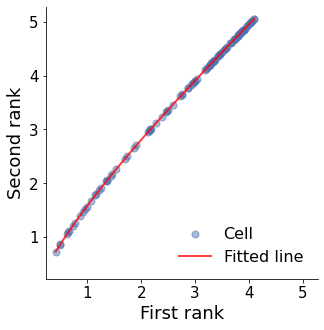

In [ ]:
plot_fitted(x,y,save='figures/realdata/auto_bc_fitted.pdf')

In [ ]:
ress

base  pseudo          loss
0    2.0     1.0  3.174833e-13
1    2.0     1.0  1.914418e-13
2    2.0     1.0  2.073553e-13
3    2.0     1.0  2.411723e-13
4    2.0     1.0  2.775597e-13
..   ...     ...           ...
95   2.0     1.0  2.630410e-13
96   2.0     1.0  2.259916e-13
97   2.0     1.0  2.724132e-13
98   2.0     1.0  2.280083e-13
99   2.0     1.0  1.839632e-13

[100 rows x 3 columns]

[<matplotlib.lines.Line2D>]

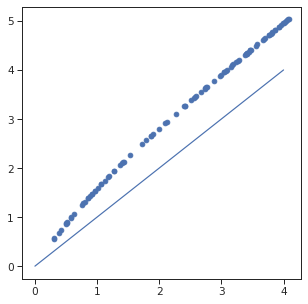

In [ ]:
plt.scatter(y1,y2)


In [ ]:
ys=[]
for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],1000),replace=False):
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(2).index)
        ys.append(y)
    except:
        print(c_idx)
ys=np.array(ys)
y1=ys[:,0]
y2=ys[:,1]

(array([  8.,  19.,  43.,  40.,  36.,  79.,  64.,  48.,  99., 564.]),
 array([0.1821543 , 0.25982992, 0.33750555, 0.41518117, 0.49285679,
        0.57053242, 0.64820804, 0.72588367, 0.80355929, 0.88123491,
        0.95891054]),
 <BarContainer object of 10 artists>)

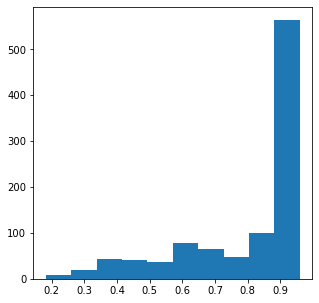

In [ ]:
figsize(5,5)
plt.hist(y2-y1)

<matplotlib.collections.PathCollection>

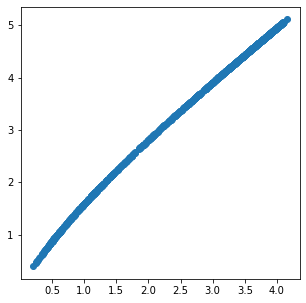

In [ ]:
plt.scatter(y1,y2)

<matplotlib.collections.PathCollection>

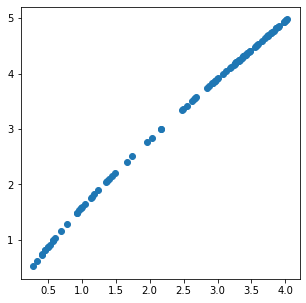

In [ ]:
plt.scatter(y1[:100],y2[:100])

##### auto 2

In [ ]:
def f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    return np.sum((u-y)**2)

def grad_f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    dudx = p[0]/((p[0]*x+p[2])*np.log(p[1]))
    dudp = 1/np.log(p[1])
    grad_u = np.vstack((dudx, np.zeros_like(p[1:]), dudp))
    return 2*np.sum(grad_u*(u-y), axis=1)
bounds = [(1e-6, None), (1.9, None), (1e-6, None)]
#res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-6, bounds=bounds, args=(x, y))

In [ ]:
ress=[]
for N in range(3,16):
    for c_idx in range(1000):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(N).index)
            x = np.arange(1, N+1)
            res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
            ress.append([res.x[0],res.x[1],res.x[2],res.fun,N,int(res.fun<10**-5)])
        except:
            pass
            #print(c_idx)
ress=pd.DataFrame(ress,columns=['s','b','c','l','n','p'])

In [ ]:
ress.n.value_counts()

3     999
4     999
5     999
6     998
7     983
8     937
9     856
10    753
11    660
12    598
13    547
14    499
15    468
Name: n, dtype: int64

<AxesSubplot:xlabel='n', ylabel='l'>

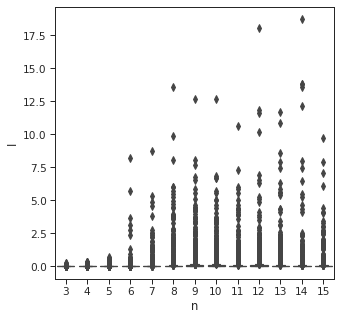

In [ ]:
sns.boxplot(data=ress,x='n',y='l')

<AxesSubplot:xlabel='n', ylabel='l'>

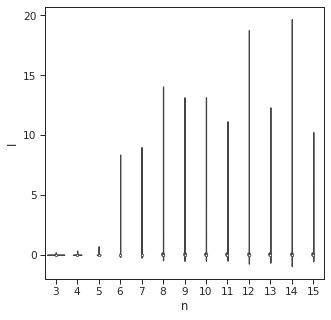

In [ ]:
sns.violinplot(data=ress,x='n',y='l')

<AxesSubplot:xlabel='n', ylabel='l'>

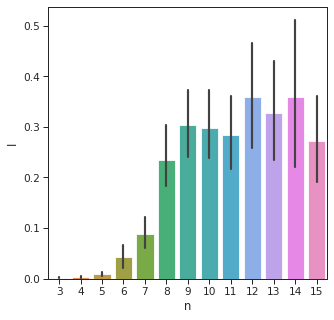

In [ ]:
sns.barplot(data=ress,x='n',y='l')

<AxesSubplot:xlabel='n', ylabel='b'>

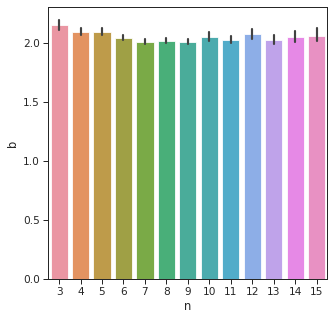

In [ ]:
sns.barplot(data=ress,x='n',y='b')

<AxesSubplot:xlabel='n', ylabel='b'>

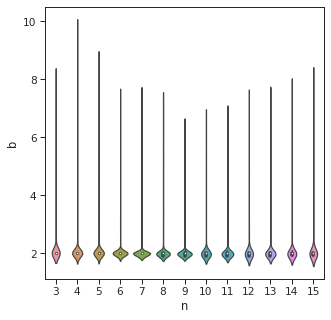

In [ ]:
sns.violinplot(data=ress,x='n',y='b')

<AxesSubplot:xlabel='n', ylabel='b'>

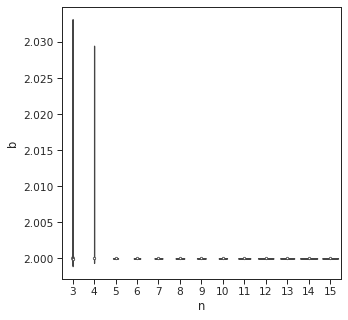

In [ ]:
sns.violinplot(data=ress[ress.p==1],x='n',y='b')

<AxesSubplot:xlabel='n', ylabel='b'>

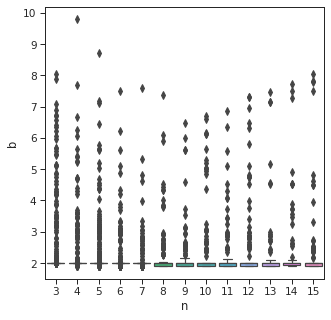

In [ ]:
sns.boxplot(data=ress,x='n',y='b')

<AxesSubplot:xlabel='n', ylabel='c'>

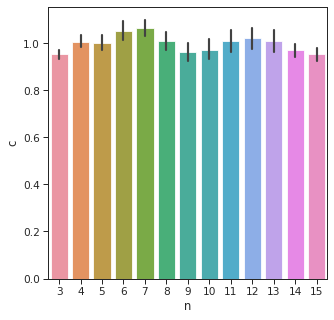

In [ ]:
sns.barplot(data=ress,x='n',y='c')

<AxesSubplot:xlabel='n', ylabel='c'>

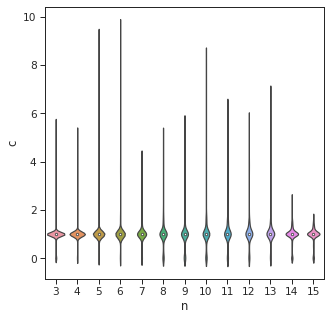

In [ ]:
sns.violinplot(data=ress,x='n',y='c')

<AxesSubplot:xlabel='n', ylabel='c'>

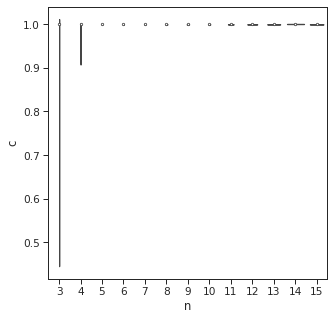

In [ ]:
sns.violinplot(data=ress[ress.p==1],x='n',y='c')

<AxesSubplot:xlabel='n', ylabel='c'>

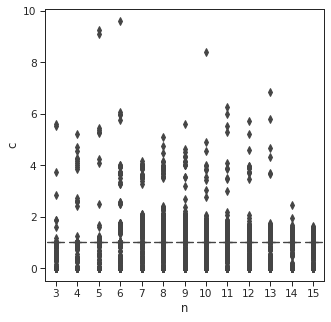

In [ ]:
sns.boxplot(data=ress,x='n',y='c')

In [ ]:
tmp=pd.DataFrame(ress[['n','p']].value_counts())

In [ ]:
ress[['n','p']]

In [ ]:
tmp.index

MultiIndex([( 4, 1),
            ( 5, 1),
            ( 3, 1),
            ( 6, 1),
            ( 7, 1),
            ( 8, 1),
            ( 9, 1),
            (10, 1),
            (11, 1),
            (12, 1),
            (13, 1),
            ( 8, 0),
            (14, 1),
            ( 9, 0),
            (15, 1),
            (10, 0),
            ( 7, 0),
            (11, 0),
            (12, 0),
            (13, 0),
            (14, 0),
            (15, 0),
            ( 6, 0),
            ( 3, 0),
            ( 5, 0),
            ( 4, 0)],
           names=['n', 'p'])

<AxesSubplot:xlabel='n', ylabel='p'>

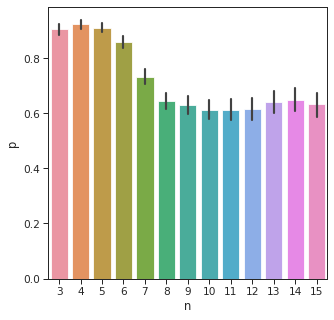

In [ ]:
sns.barplot(data=ress,x='n',y='p')

<AxesSubplot:xlabel='n', ylabel='b'>

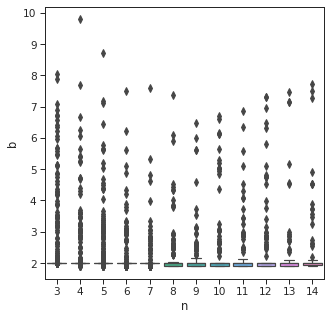

In [ ]:
sns.boxplot(data=ress,x='n',y='b')

In [ ]:
sns.boxplot(data=ress,x='n',y='c')

<AxesSubplot:xlabel='c', ylabel='b'>

In [ ]:
ress=[]
for N in range(3,20,2):
    for c_idx in range(1000):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(N).index)
            x = np.arange(1, N+1)
            res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
            ress.append([res.x[0],res.x[1],res.x[2],res.fun,N])
        except:
            print(c_idx)
ress=pd.DataFrame(ress,columns=['s','b','c','l','n'])

766


In [ ]:
ress

s         b         c             l  n
0    12.919781  1.999997  1.000038  8.522528e-13  5
1     0.415933  1.999988  1.000003  8.414166e-13  5
2    12.048134  1.999999  1.000042  7.520785e-12  5
3     5.646485  1.999997  1.000018  5.087975e-13  5
4    11.173031  1.999996  1.000058  1.425623e-12  5
..         ...       ...       ...           ... ..
994   1.161019  1.999992  1.000007  4.392555e-12  5
995   9.000789  1.999996  1.000044  1.183815e-12  5
996   8.278043  1.999996  1.000041  1.222145e-12  5
997   2.006004  1.999996  1.000006  4.773258e-13  5
998   5.675309  1.999996  1.000025  9.869319e-13  5

[999 rows x 5 columns]

<matplotlib.collections.PathCollection>

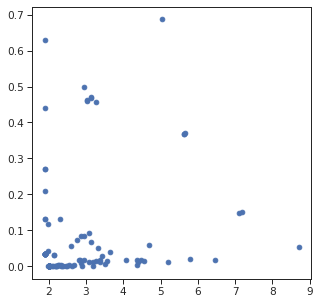

In [ ]:
plt.scatter(ress.b,ress.l)

In [ ]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.8909219412194807e-12
        x: [ 8.960e+00  2.000e+00  1.000e+00]
      nit: 44
      jac: [ 6.653e-07 -1.536e-05  1.956e-07]
     nfev: 216
     njev: 54
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [ ]:
ress=[]
for c_idx in range(10):
    N = 5
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [10,20,1], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[12.91978105  1.99999715  1.0000377 ] 8.522528196448216e-13 8.522528196448216e-13 True
[0.41593257 1.99998818 1.00000262] 8.414165889676909e-13 8.414165889676909e-13 True
[12.04813401  1.99999896  1.00004158] 7.520784676094187e-12 7.520784676094187e-12 True
[5.64648506 1.99999715 1.00001784] 5.087974729865306e-13 5.087974729865306e-13 True
[11.17303143  1.9999956   1.00005827] 1.4256230721496522e-12 1.4256230721496522e-12 True
[12.1063489   1.99999506  1.00007206] 1.7397874043013997e-12 1.7397874043013997e-12 True
[12.56265641  1.99999599  1.00006033] 1.3976764403191217e-12 1.3976764403191217e-12 True
[12.13579402  1.99999672  1.00005045] 9.848476073013258e-13 9.848476073013258e-13 True
[11.68206881  1.99999523  1.00006807] 1.6369869977364646e-12 1.6369869977364646e-12 True
[8.96049377 1.99999679 1.00002832] 1.8909219412194807e-12 1.8909219412194807e-12 True


In [ ]:
ress=[]
for c_idx in range(10):
    N = 4
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [10,20,1], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[12.91963045  1.99999341  1.00009595] 1.46185758742833e-12 1.46185758742833e-12 True
[0.66973345 2.4841373  0.89998757] 0.00037449869230633635 0.00037449869230633635 True
[13.43358768  2.03495992  0.41720509] 6.66121528278842e-05 6.66121528278842e-05 True
[5.64644428 1.99999421 1.00003148] 9.474724196867107e-13 9.474724196867107e-13 True
[11.17313434  1.99999842  1.00001462] 2.4156167430203565e-13 2.4156167430203565e-13 True
[12.10652795  1.99999943  0.99997839] 4.146482109764431e-12 4.146482109764431e-12 True
[12.56256     1.9999934   1.00008797] 1.515988725599611e-12 1.515988725599611e-12 True
[12.13565194  1.99999273  1.00009364] 1.8556179424955717e-12 1.8556179424955717e-12 True
[11.68183086  1.99998795  1.00024663] 2.701114665260063e-10 2.701114665260063e-10 True
[8.96065277 2.00000357 0.99999244] 5.5987000107127236e-12 5.5987000107127236e-12 True


In [ ]:
ress=[]
for c_idx in range(10):
    N = 3
    c = pd.Series(smtx2.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(1, N+1)
    res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
    #res = minimize(f1, [10,20,1], method='Nelder-Mead', tol=1e-6)
    ress.append(res.x[1])
    print(res.x,f1(res.x,x,y),res.fun,res.success)

[12.91932966  1.9999854   1.00018454] 2.099254965910514e-12 2.099254965910514e-12 True
[0.41591392 1.99994771 1.00000667] 1.3204044709359555e-12 1.3204044709359555e-12 True
[12.06744608  2.00055814  0.99391373] 1.0212584928631949e-08 1.0212584928631949e-08 True
[5.64634483 1.99998685 1.00006444] 1.4025260142496106e-12 1.4025260142496106e-12 True
[11.17266838  1.99998415  1.00017135] 2.4044101258061876e-12 2.4044101258061876e-12 True
[12.10602603  1.99998572  1.00016463] 2.0296389153308184e-12 2.0296389153308184e-12 True
[12.56218717  1.99998335  1.0002045 ] 2.738213259203418e-12 2.738213259203418e-12 True
[12.13545415  1.999987    1.00015507] 1.6944078840668408e-12 1.6944078840668408e-12 True
[11.68171771  1.99998469  1.00017147] 2.2652938609622714e-12 2.2652938609622714e-12 True
[8.96021567 1.99998552 1.00012128] 1.9356895334767772e-12 1.9356895334767772e-12 True


### Cells

In [ ]:
cmap = plt.get_cmap("tab10")

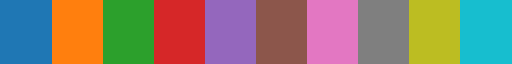

In [ ]:
cmap

In [ ]:
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
def RCplot1(smtx,xl='Rank of count frequency',yl='Value',xm=None,ym=None,alpha=1,save=None,show_legend=True):
    fig, ax = plt.subplots()
    for c_idx,m in zip(range(smtx.shape[0]),['s','*','o']):
        c = pd.Series(smtx.getrow(c_idx).data)
        c=c.value_counts().sort_index()
        y = np.array(c.index)
        x = np.arange(0, c.shape[0])+1
        ax.scatter(x, y,alpha=alpha,label=f'Cell {c_idx+1}',s=60,linewidth=3,marker=m,facecolors='none', edgecolors=cmap(c_idx))
        ax.set_facecolor('none')


    ax.legend(fontsize=15,frameon=False)#,bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlabel(xl,fontsize=18)
    ax.set_ylabel(yl,fontsize=18)
    if not show_legend:
        ax.legend().set_visible(False)
    if ym:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.set_ylim(0, ym)
    if xm:
        ax.set_xlim(0, xm)
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

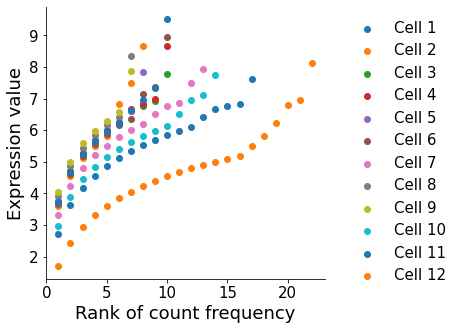

In [ ]:
figsize(5,5)
RCplot1(smtx2[3:15],yl='Expression value',save='figures/realdata/rankvsexpr.pdf')

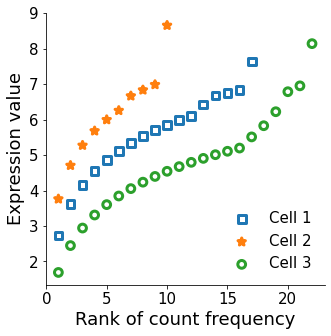

In [ ]:
figsize(5,5)
RCplot1(smtx2[[3,6,14]],yl='Expression value',save='figures/realdata/rankvsexpr.pdf')

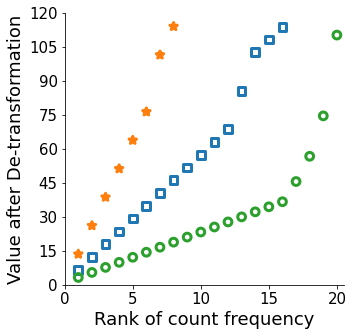

In [ ]:
tmp=smtx2[[3,6,14]].copy()
tmp.data=2**tmp.data
RCplot1(tmp,xm=20.5,ym=120,yl='Value after De-transformation',show_legend=False,save='figures/realdata/rankvsexpr_detransform.pdf')

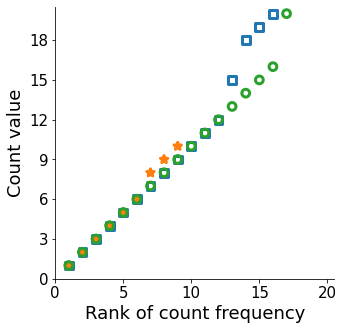

In [ ]:
tmp=smtx[[3,6,14]].copy()
RCplot1(tmp,xm=20.5,ym=20.5,yl='Count value',show_legend=False,save='figures/realdata/rankvscount.pdf')

In [ ]:
tmp=[len(np.unique(smtx2.getrow(i).data)) for i in range(1000)]

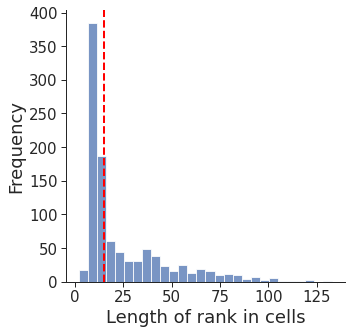

In [ ]:
fig, ax = plt.subplots()
sns.histplot(tmp,ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel('Length of rank in cells',fontsize=18)
ax.set_ylabel('Frequency',fontsize=18)
plt.axvline(x=15, color='red', linestyle='--', linewidth=2)
plt.savefig('figures/realdata/length_rank.pdf',dpi=300, bbox_inches='tight',transparent=True)

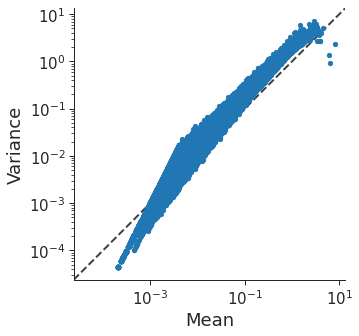

In [ ]:
cmean = np.array(smtx2.mean(0))
cvar = np.array(smtx2.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='#2077B4',fit=False,save='figures/realdata/mvsv_expr.pdf')

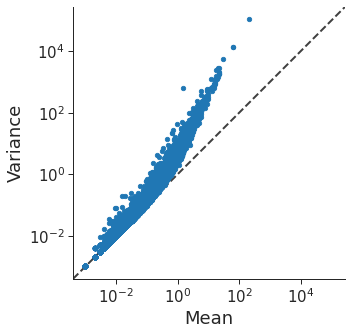

In [ ]:
cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='#2077B4',fit=False,save='figures/realdata/mvsv_count.pdf')

- total expression distribution

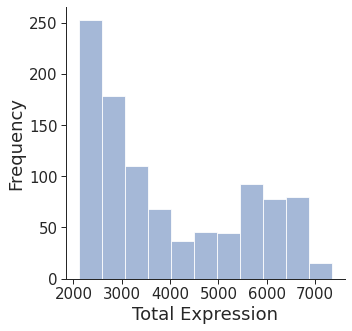

In [ ]:
histplot(smtx2.sum(axis=1),color="#55A868",xl='Total Expression',save='figures/realdata/total_expr.pdf')

- total expression distribution

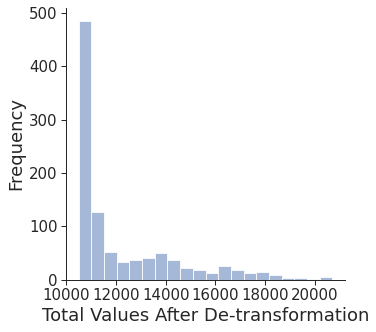

In [ ]:
smtx1=smtx2.copy()
smtx1.data=2**smtx1.data
histplot(smtx1.sum(axis=1),color="#55A868",xl='Total Values After De-transformation',save='figures/realdata/total_devalues.pdf')

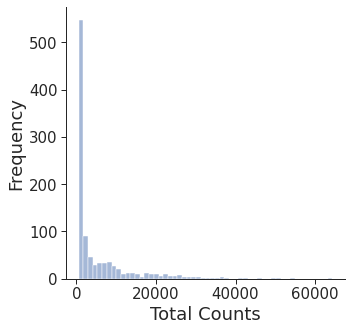

In [ ]:
histplot(smtx.sum(axis=1),color="#55A868",xl='Total Counts',save='figures/realdata/total_counts.pdf')

In [ ]:
smtx1=ad.layers['expr'].copy()
smtx1.data=2**smtx1.data
smtx1.data=smtx1.data-1

In [ ]:
pd.DataFrame(smtx1.sum(axis=1),columns=['total'])

total
0    10000.0
1    10000.0
2    10000.0
3    10000.0
4    10000.0
..       ...
995  10000.0
996  10000.0
997  10000.0
998  10000.0
999  10000.0

[1000 rows x 1 columns]

In [ ]:
sns.boxplot

<function seaborn.categorical.boxplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5, ax=None, **kwargs)>

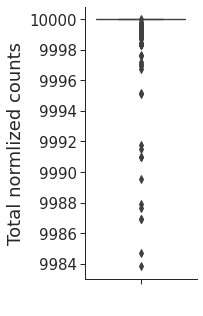

In [ ]:
figsize(2,5)
fig,ax=plt.subplots()
sns.boxplot(data=pd.DataFrame(smtx1.sum(axis=1),columns=['total']),y='total',color='#2077B4',ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(' ',fontsize=18)
ax.set_ylabel('Total normlized counts',fontsize=18)
plt.savefig('figures/realdata/ng_vs_tnc_boxp.pdf',dpi=300, bbox_inches='tight',transparent=True)

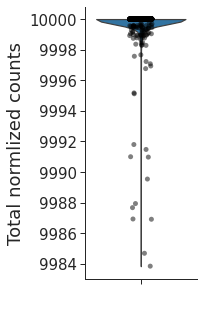

In [ ]:
figsize(2,5)
fig,ax=plt.subplots()
sns.violinplot(data=pd.DataFrame(smtx1.sum(axis=1),columns=['total']),y='total',color='#2077B4',ax=ax,cut=0)
sns.stripplot(data=pd.DataFrame(smtx1.sum(axis=1),columns=['total']), y='total', jitter=True, color='black', alpha=0.5, ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(' ',fontsize=18)
ax.set_ylabel('Total normlized counts',fontsize=18)
plt.savefig('figures/realdata/ng_vs_tnc_violin.pdf',dpi=300, bbox_inches='tight',transparent=True)

/home/huang_yin/anaconda3/envs/sc06/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

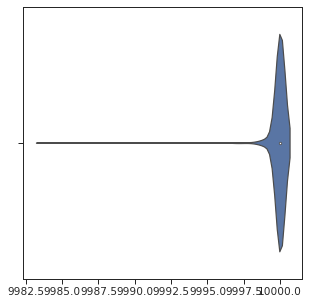

In [ ]:
sns.violinplot(smtx1.sum(axis=1))

[<matplotlib.lines.Line2D>]

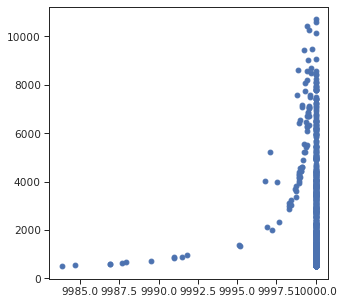

In [ ]:
figsize(5,5)
plt.plot(smtx1.sum(axis=1),(smtx1>0).sum(axis=1),'o')

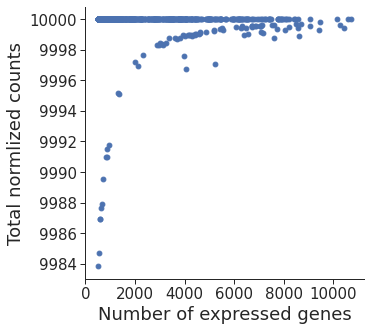

In [ ]:
fig,ax=plt.subplots()
ax.plot((smtx1>0).sum(axis=1),smtx1.sum(axis=1),'o')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel('Number of expressed genes',fontsize=18)
ax.set_ylabel('Total normlized counts',fontsize=18)
plt.savefig('figures/realdata/ng_vs_tnc.pdf',dpi=300, bbox_inches='tight',transparent=True)

[<matplotlib.lines.Line2D>]

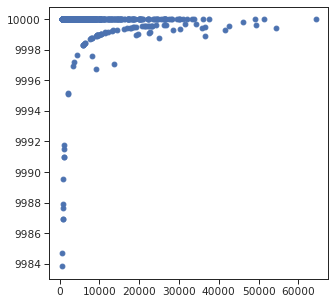

In [ ]:
plt.plot(smtx.sum(axis=1),smtx1.sum(axis=1),'o')

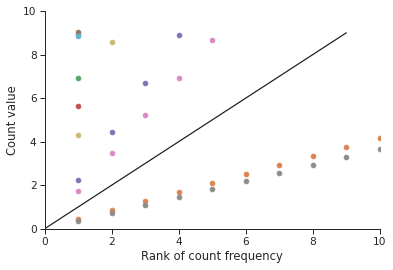

In [ ]:
RCplot(smtx1[:20],xm=10,ym=10)

### errors

In [ ]:
np.random.seed(0)
num=100
ress=[]
for _ in range(num):
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    ress.append([res.x[0],res.x[1],res.fun])

In [ ]:
ress=pd.DataFrame(ress,columns=['base','pseudo','loss'])

In [ ]:
ress.base.mean()

1.999999988785788

In [ ]:
ress.pseudo.mean()

1.0000000559615259

In [ ]:
ad.X.data

array([3.79907659, 3.79907659, 3.79907659, ..., 3.62652532, 2.73884757,
       3.62652532])

In [ ]:
ad1=scdenorm(ad,rint=False,base=ress.base.mean(),cont=ress.pseudo.mean())

100%|██████████| 1000/1000 [00:00<00:00, 1717.69it/s]


In [ ]:
ad1.X

<1000x36501 sparse matrix of type '<class 'numpy.float64'>'
	with 2173216 stored elements in Compressed Sparse Row format>

In [ ]:
ad1.layers['counts']

<1000x36501 sparse matrix of type '<class 'numpy.float32'>'
	with 2173216 stored elements in Compressed Sparse Row format>

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

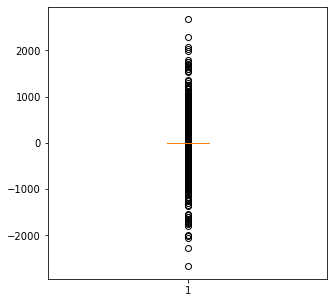

In [ ]:
plt.boxplot(ad1.X.data-ad1.layers['counts'].data)

In [ ]:
ad1

AnnData object with n_obs × n_vars = 1000 × 36501
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids', 'gene_name'
    layers: 'counts', 'expr'

In [ ]:
tmp1=ad1.X.todense()

In [ ]:
tmp1

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 7.00000077, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 9.00000012, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
tmp=ad.layers['counts'].todense()

In [ ]:
tmp2=abs(tmp-tmp1)

In [ ]:
tmp2.max()

0.0008531218181815348

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

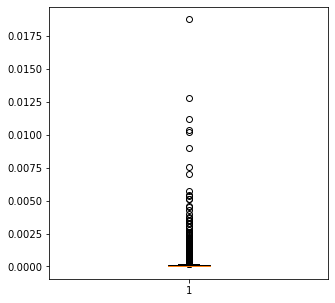

In [ ]:
plt.boxplot(tmp2.sum(axis=1))

(array([890.,  36.,  24.,  14.,  12.,   6.,   3.,   2.,   4.,   1.,   0.,
          1.,   1.,   0.,   1.,   0.,   2.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.79741327e-08, 6.25836655e-04, 1.25162534e-03, 1.87741402e-03,
        2.50320270e-03, 3.12899138e-03, 3.75478006e-03, 4.38056874e-03,
        5.00635742e-03, 5.63214610e-03, 6.25793478e-03, 6.88372346e-03,
        7.50951214e-03, 8.13530082e-03, 8.76108950e-03, 9.38687818e-03,
        1.00126669e-02, 1.06384555e-02, 1.12642442e-02, 1.18900329e-02,
        1.25158216e-02, 1.31416103e-02, 1.37673989e-02, 1.43931876e-02,
        1.50189763e-02, 1.56447650e-02, 1.62705537e-02, 1.68963424e-02,
        1.75221310e-02, 1.81479197e-02, 1.87737084e-02]),
 <BarContainer object of 30 artists>)

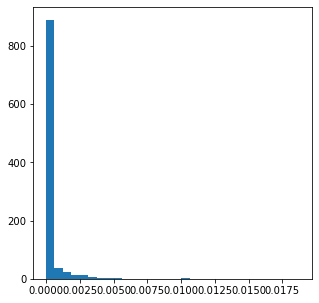

In [ ]:
figsize(5,5)
plt.hist(tmp2.sum(axis=1),bins=30)

In [ ]:
pd.DataFrame(tmp2.sum(axis=1),columns=['total'])

total
0    0.000001
1    0.002083
2    0.000002
3    0.000003
4    0.000002
..        ...
995  0.000160
996  0.000002
997  0.000003
998  0.000039
999  0.000002

[1000 rows x 1 columns]

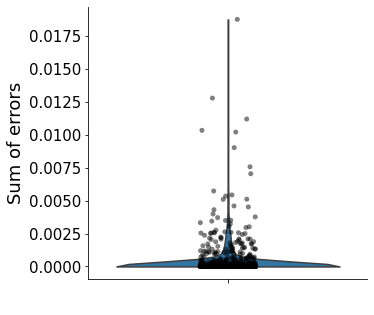

In [ ]:
#figsize(2,5)
fig,ax=plt.subplots()
sns.violinplot(data=pd.DataFrame(tmp2.sum(axis=1),columns=['total']),y='total',color='#2077B4',ax=ax,cut=0)
sns.stripplot(data=pd.DataFrame(tmp2.sum(axis=1),columns=['total']), y='total', jitter=True, color='black', alpha=0.5, ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(' ',fontsize=18)
ax.set_ylabel('Sum of errors',fontsize=18)
plt.savefig('figures/realdata/sum_error_violin.pdf',dpi=300, bbox_inches='tight',transparent=True)

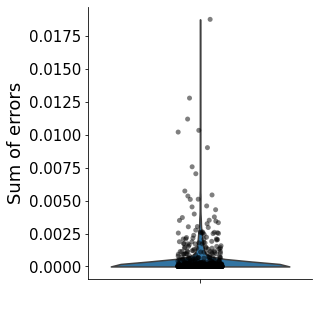

In [ ]:
figsize(4,5)
fig,ax=plt.subplots()
sns.violinplot(data=pd.DataFrame(tmp2.sum(axis=1),columns=['total']),y='total',color='#2077B4',ax=ax,cut=0)
sns.stripplot(data=pd.DataFrame(tmp2.sum(axis=1),columns=['total']), y='total', jitter=True, color='black', alpha=0.5, ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(' ',fontsize=18)
ax.set_ylabel('Sum of errors',fontsize=18)
plt.savefig('figures/realdata/sum_error_violin.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
sum(ad1.X.data-ad.layers['counts'].data)

4.65841182517579e-07

In [ ]:
ad.layers['counts'].data

array([1., 1., 1., ..., 2., 1., 2.], dtype=float32)

## ALL genes

## HVG genes

## Failure case

In [ ]:
./human_brain_microglia_Xu_2020_10x/h5/GSE129178_mfy-scale-data_denorm.h5ad
./human_brain_vascular_Crouch_2022_10x/h5/crouch_data_denorm.h5ad
./human_brain_glial_Venteicher_Smartseq2/h5/GSE89567_IDH_A_processed_data_denorm.h5ad
./human_brain_cortex_Eze_2021_10x/h5/umap_denorm.h5ad
./human_brain_MultipleCorticalAreas_AllenBrain_2019_SMART-Seq/h5/ftOutlier_umap.h5ad

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_microglia_Xu_2020_10x/h5/GSE129178_mfy-scale-data.h5ad') 
#RCplot1(ad.X[:5])

In [ ]:
ad.X

array([[-0.20141028, -0.15626802, -0.23807818, ..., -0.23493879,
        -0.24652678, -0.29204887],
       [-0.14345226, -0.05447611, -0.08136047, ..., -0.18011162,
        -0.1540402 , -0.20095001],
       [-0.16221347, -0.15595333, -0.26613173, ..., -0.17289114,
        -0.22271599, -0.2702969 ],
       ...,
       [-0.14468431, -0.17758429, -0.3212638 , ..., -0.13721019,
        -0.22437492, -0.27323246],
       [-0.2625922 , -0.2646797 ,  2.1606019 , ..., -0.29246676,
        -0.34469923,  2.2965047 ],
       [-0.37100264, -0.34114265,  1.537161  , ...,  2.8367276 ,
        -0.4532868 , -0.4929012 ]], dtype=float32)

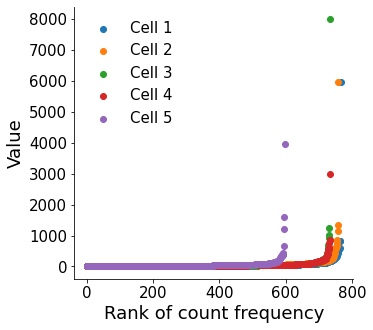

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_vascular_Crouch_2022_10x/h5/crouch_data.h5ad') 
RCplot1(ad.X[:5])

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_glial_Venteicher_Smartseq2/h5/GSE89567_IDH_A_processed_data.h5ad') 
#RCplot1(ad.X[:5])

In [ ]:
ad.X=sparse.csr_matrix(ad.X)

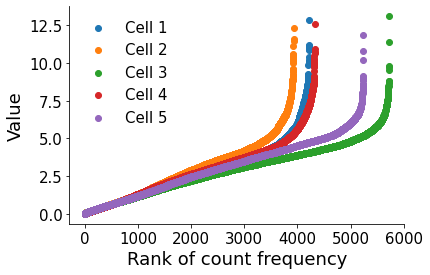

In [ ]:
RCplot1(ad.X[:5])

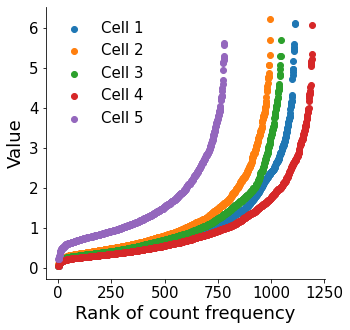

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_cortex_Eze_2021_10x/h5/human_brain_cortex_Eze_2021_10x.h5ad') 
RCplot1(ad.X[:5])

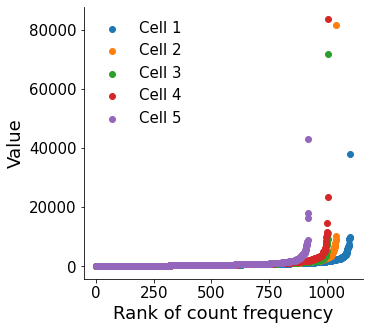

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_MultipleCorticalAreas_AllenBrain_2019_SMART-Seq/h5/ftOutlier_umap.h5ad') 
RCplot1(ad.X[:5])

## Time benchmark

# END

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YPBBA1

the data is already noramlized to 10,000 counts per cells and then log normalized such the values in the file are =log2(counts+1)

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/mouse_brain_BasalGanglia_Wallace_2017_Drop-seq/h5/mouse_brain_BasalGanglia_Wallace_2017_Drop-seq.h5ad')

In [ ]:
ad

AnnData object with n_obs × n_vars = 3101 × 16484
    var: 'geneInfo'

In [ ]:
smtx=ad.X

In [ ]:
smtx

<3101x16484 sparse matrix of type '<class 'numpy.float32'>'
	with 3117005 stored elements in Compressed Sparse Row format>

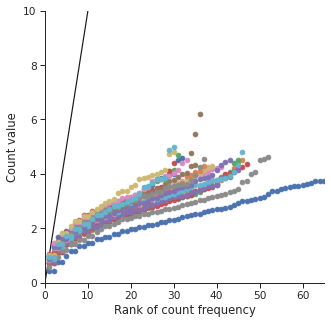

In [ ]:
RCplot(smtx[:20],xm=65,ym=10)

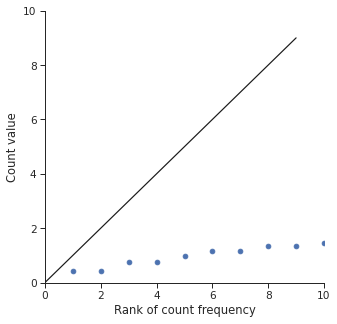

In [ ]:
RCplot(smtx[:1],xm=10,ym=10)

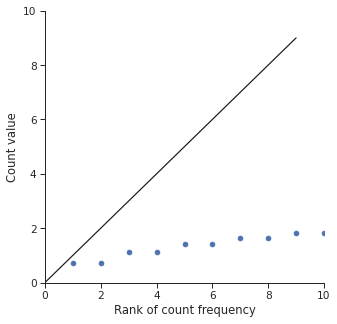

In [ ]:
RCplot(smtx[2],xm=10,ym=10)

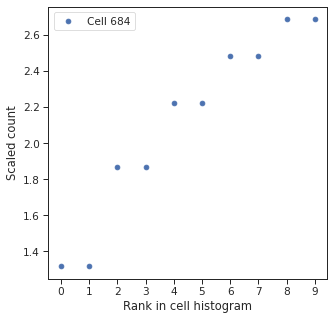

In [ ]:
for c_idx in [684]:
    N = 10
    c = pd.Series(smtx.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(0, N)
    plt.scatter(x, y, label=f'Cell {c_idx}');
    

plt.legend()
plt.xlabel('Rank in cell histogram')
plt.ylabel('Scaled count');
plt.xticks(x);

/tmp/ipykernel_28611/2730932830.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1, zorder=ms.shape[0],color='red', label='line')


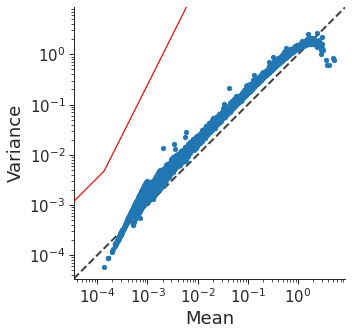

In [ ]:
#figsize(5,5)
cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='#2077B4',fit=True)

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_mouse_brain_source_Gaublomme_2019/h5/experiment2_mouse_pbs.scp.h5ad')

In [ ]:
smtx=ad.X

In [ ]:
smtx

<3402x20921 sparse matrix of type '<class 'numpy.float32'>'
	with 5798103 stored elements in Compressed Sparse Row format>

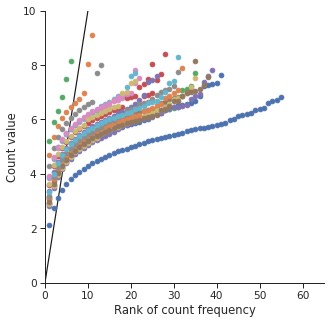

In [ ]:
RCplot(smtx[:20],xm=65,ym=10)

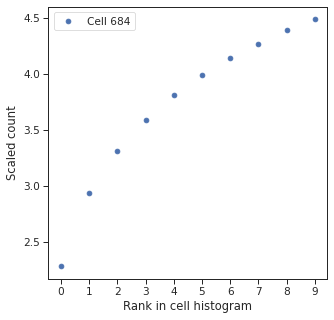

In [ ]:
for c_idx in [684]:
    N = 10
    c = pd.Series(smtx.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(0, N)
    plt.scatter(x, y, label=f'Cell {c_idx}');
    

plt.legend()
plt.xlabel('Rank in cell histogram')
plt.ylabel('Scaled count');
plt.xticks(x);

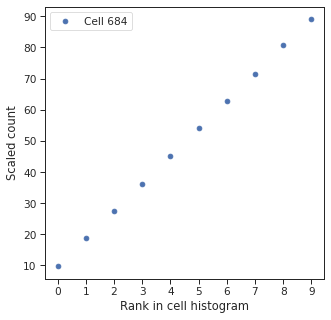

In [ ]:
for c_idx in [684]:
    N = 10
    c = pd.Series(smtx.getrow(c_idx).data)
    y = np.array(c.value_counts().sort_index().head(N).index)
    x = np.arange(0, N)
    plt.scatter(x, np.exp(y), label=f'Cell {c_idx}');
    

plt.legend()
plt.xlabel('Rank in cell histogram')
plt.ylabel('Scaled count');
plt.xticks(x);

In [ ]:
np.exp(y)

array([ 9.77668013, 18.72763175, 27.3851239 , 36.23407282, 45.15043628,
       54.05488988, 62.80281306, 71.52163426, 80.64040821, 89.12142548])

/tmp/ipykernel_28611/2730932830.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1, zorder=ms.shape[0],color='red', label='line')


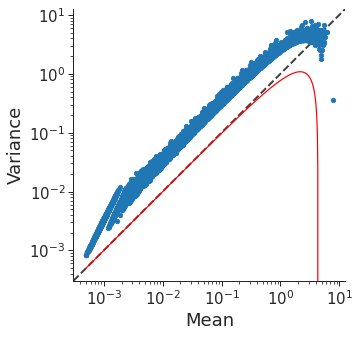

In [ ]:
#figsize(5,5)
cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='#2077B4',fit=True)